Data Set:

You have been provided 4 individual data sets. Time period of data is from 31/01/2016 to 31/12/2018.

Below are the list of datasets which are provided for the analysis:

Cab_Data.csv – this file includes details of transaction for 2 cab companies

Customer_ID.csv – this is a mapping table that contains a unique identifier which links the customer’s demographic details

Transaction_ID.csv – this is a mapping table that contains transaction to customer mapping and payment mode

City.csv – this file contains list of US cities, their population and number of cab users

 # Business problem
 Understanding the market in order to make decision regarding investment in Cab industries.

In [114]:
from sqlalchemy_schemadisplay import create_schema_graph
from sqlalchemy import MetaData,inspect,create_engine,Table, Column, Integer, String
import pandas as pd 
import matplotlib.image as mpimg
from eralchemy import render_er
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
from scipy import stats

In [115]:
df1=pd.read_csv('Cab_Data.csv')
df2=pd.read_csv('City.csv')
df3=pd.read_csv('Customer_ID.csv')
df4=pd.read_csv('Transaction_ID.csv')

In [116]:
df4.info('memory usage')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440098 entries, 0 to 440097
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Transaction ID  440098 non-null  int64 
 1   Customer ID     440098 non-null  int64 
 2   Payment_Mode    440098 non-null  object
dtypes: int64(2), object(1)
memory usage: 10.1+ MB


In [117]:
for db in [df1,df2,df3,df4]:
    print(f'the dataframe {db.shape}')

the dataframe (359392, 7)
the dataframe (20, 3)
the dataframe (49171, 4)
the dataframe (440098, 3)


In [118]:
df2['City_Population']=pd.to_numeric(df2.Population.str.replace(',',''))
df2['City_Users']=pd.to_numeric(df2.Users.str.replace(',',''))
df2.drop(['Population','Users'],axis=1,inplace=True)

In [119]:
engine = create_engine('sqlite://', echo=False)

In [120]:
df1.to_sql('Cab_data', con=engine ,)
df2.to_sql('City', con=engine, )
df3.to_sql('Customer', con=engine, )
df4.to_sql('Transaction', con=engine, )

440098

In [121]:
print(engine.url)

sqlite://


In [122]:
#engine.execute('select * from City').fetchall()

In [123]:
#engine.execute('ALTER TABLE CITY ADD PRIMARY KEY (City)')

In [124]:
conn = engine.connect()
inspector = inspect(conn)
inspector.get_table_names() 

['Cab_data', 'City', 'Customer', 'Transaction']

In [125]:
for count,tble in enumerate(inspector.get_table_names()): 
    print(f'{count+1}- Table {tble}:...........')
    columns = inspector.get_columns(tble)

    for column in columns:
        #print(f'    {column["name"]}:: {column["type"]}')
         #print(f'    {column}')
        if 'ID' in column['name']:
             column['primary_key']=1
        print(f'    {column["name"]}:: {column["type"]} :: {column["primary_key"]}  ')     

1- Table Cab_data:...........
    index:: BIGINT :: 0  
    Transaction ID:: BIGINT :: 1  
    Date of Travel:: BIGINT :: 0  
    Company:: TEXT :: 0  
    City:: TEXT :: 0  
    KM Travelled:: FLOAT :: 0  
    Price Charged:: FLOAT :: 0  
    Cost of Trip:: FLOAT :: 0  
2- Table City:...........
    index:: BIGINT :: 0  
    City:: TEXT :: 0  
    City_Population:: BIGINT :: 0  
    City_Users:: BIGINT :: 0  
3- Table Customer:...........
    index:: BIGINT :: 0  
    Customer ID:: BIGINT :: 1  
    Gender:: TEXT :: 0  
    Age:: BIGINT :: 0  
    Income (USD/Month):: BIGINT :: 0  
4- Table Transaction:...........
    index:: BIGINT :: 0  
    Transaction ID:: BIGINT :: 1  
    Customer ID:: BIGINT :: 1  
    Payment_Mode:: TEXT :: 0  


tables er

In [188]:
graph = create_schema_graph(metadata=MetaData(inspector))
                           

In [127]:
graph.set('scale', 4)
graph.set('arrowhead' , 'diamond')
graph.set('color','red')
graph.write_png('cab_data_er.png') # write out the file


### Creating master data 
1. Joining the City file  and the Cab_Data file based on the city columns.
2. in order to join the customer id with the previous step data we need first to join the previous step with Transcation ID file on Transaction ID column then we join the result with the Customer ID file.  

In [128]:

df=df1.merge(df2,on='City').merge(df4,on='Transaction ID').merge(df3,on='Customer ID')

In [129]:
# check fo the duplicated rows
df.duplicated().any()

False

In [130]:
# check for the nan values
df.isna().any()

Transaction ID        False
Date of Travel        False
Company               False
City                  False
KM Travelled          False
Price Charged         False
Cost of Trip          False
City_Population       False
City_Users            False
Customer ID           False
Payment_Mode          False
Gender                False
Age                   False
Income (USD/Month)    False
dtype: bool

In [131]:
df['Income']=df['Income (USD/Month)'] 

In [132]:
#drop unnecessary columns
df.drop(columns=['Customer ID','Income (USD/Month)'],axis=1,inplace=True)

In [133]:
data=df.copy()
data.shape

(359392, 13)

In [134]:
# convert Data_Travel to date time format
data['Date_Travel']=pd.to_datetime(data['Date of Travel'],unit='D', origin=pd.Timestamp('1900-01-01'))

In [135]:
data['Year']=data['Date_Travel'].dt.isocalendar()['year']
data['Week']=data['Date_Travel'].dt.isocalendar()['week']
data['Day']=data['Date_Travel'].dt.isocalendar()['day']
data['Month']=data['Date_Travel'].dt.month


In [136]:
# create a columns for which season (winter,spring,summer,fall)
data['Season']=data.Month.apply(lambda month:month%12 // 3 + 1 ).replace({1:'winter',2:'spring',3:'summer',4:'fall'})

In [137]:
# create a columns for the ratio of number of the users per city population
data['User_to_Population']=100*data['City_Users']/data['City_Population']

In [138]:
data.drop(['Date of Travel'],axis=1,inplace=True)

In [139]:
# create column for the profit each combony make. 
data['Profit']=data['Price Charged']-data['Cost of Trip']

In [140]:
data['City'].replace('SILICON VALLEY','SILICON VALLEY CA',inplace=True)
data['City'].replace('ORANGE COUNTY','CA',inplace=True)
data[['City','State']]=data.City.str.strip().str.rsplit(' ',1,expand=True)

### Describing the dataset

In [141]:
data.describe(include='object')

,Company,City,Payment_Mode,Gender,Season,State
count,359392,359392,359392,359392,359392,355410
unique,2,19,2,2,4,13
top,Yellow Cab,NEW YORK,Card,Male,fall,NY
freq,274681,99885,215504,205912,119916,99885


In [142]:
data.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
Transaction ID,359392.0,1.022076e+07,1.268058e+05,1.000001e+07,1.011081e+07,1.022104e+07,1.033094e+07,1.044011e+07
KM Travelled,359392.0,2.256725e+01,1.223353e+01,1.900000e+00,1.200000e+01,2.244000e+01,3.296000e+01,4.800000e+01
Price Charged,359392.0,4.234433e+02,2.743789e+02,1.560000e+01,2.064375e+02,3.863600e+02,5.836600e+02,2.048030e+03
Cost of Trip,359392.0,2.861901e+02,1.579937e+02,1.900000e+01,1.512000e+02,2.824800e+02,4.136832e+02,6.912000e+02
City_Population,359392.0,3.132198e+06,3.315194e+06,2.489680e+05,6.712380e+05,1.595037e+06,8.405837e+06,8.405837e+06
City_Users,359392.0,1.583656e+05,1.008501e+05,3.643000e+03,8.002100e+04,1.441320e+05,3.021490e+05,3.021490e+05
Age,359392.0,3.533670e+01,1.259423e+01,1.800000e+01,2.500000e+01,3.300000e+01,4.200000e+01,6.500000e+01
Income,359392.0,1.504882e+04,7.969409e+03,2.000000e+03,8.424000e+03,1.468500e+04,2.103500e+04,3.500000e+04
Year,359392.0,2.017054e+03,8.071087e-01,2.016000e+03,2.016000e+03,2.017000e+03,2.018000e+03,2.019000e+03
Week,359392.0,3.049987e+01,1.521279e+01,1.000000e+00,1.800000e+01,3.300000e+01,4.400000e+01,5.200000e+01


In [143]:
# how many values in each column 
for col in data.select_dtypes('object').columns.tolist():
    print(f'Feature:{col}-------------')
    print(f'{data[col].value_counts()}' )

Feature:Company-------------
Yellow Cab    274681
Pink Cab       84711
Name: Company, dtype: int64
Feature:City-------------
NEW YORK          99885
CHICAGO           56625
LOS ANGELES       48033
WASHINGTON        43737
BOSTON            29692
SAN DIEGO         20488
SILICON VALLEY     8519
SEATTLE            7997
ATLANTA            7557
DALLAS             7017
MIAMI              6454
AUSTIN             4896
CA                 3982
DENVER             3825
NASHVILLE          3010
SACRAMENTO         2367
PHOENIX            2064
TUCSON             1931
PITTSBURGH         1313
Name: City, dtype: int64
Feature:Payment_Mode-------------
Card    215504
Cash    143888
Name: Payment_Mode, dtype: int64
Feature:Gender-------------
Male      205912
Female    153480
Name: Gender, dtype: int64
Feature:Season-------------
fall      119916
winter     89881
summer     82769
spring     66826
Name: Season, dtype: int64
Feature:State-------------
NY    99885
CA    79407
IL    56625
DC    43737
MA    2969

In [144]:
# function to plot a boxplot and a histogram along the same scale.

sns.set_theme('talk')
sns.set_style('white')
def histogram_boxplot(df, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=df, x=feature, ax=ax_box2, showmeans=True, color="red"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=df, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="rgb"
    ) if bins else sns.histplot(
        data=df, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        df[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        df[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram
    f2.savefig(f'{feature}_hist.png',dpi=200)

In [145]:
# function to create labeled barplots

sns.set_theme('talk')
sns.set_style('white')
def labeled_barplot(df, feature, perc=True, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(df[feature])  # length of the column
    count = df[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=df,
        x=feature,
        palette="Paired",
        order=df[feature].value_counts().sort_values(ascending=False).index[:n]
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [146]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
   
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.xlabel('{}'.format(predictor.replace('_',' ').title()))
    plt.ylabel('{}'.format(target.replace('_',' ').title()))
    
    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 24

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.savefig(predictor+target+'_stakedbars.png',bbox_inches='tight') # save
    plt.show()

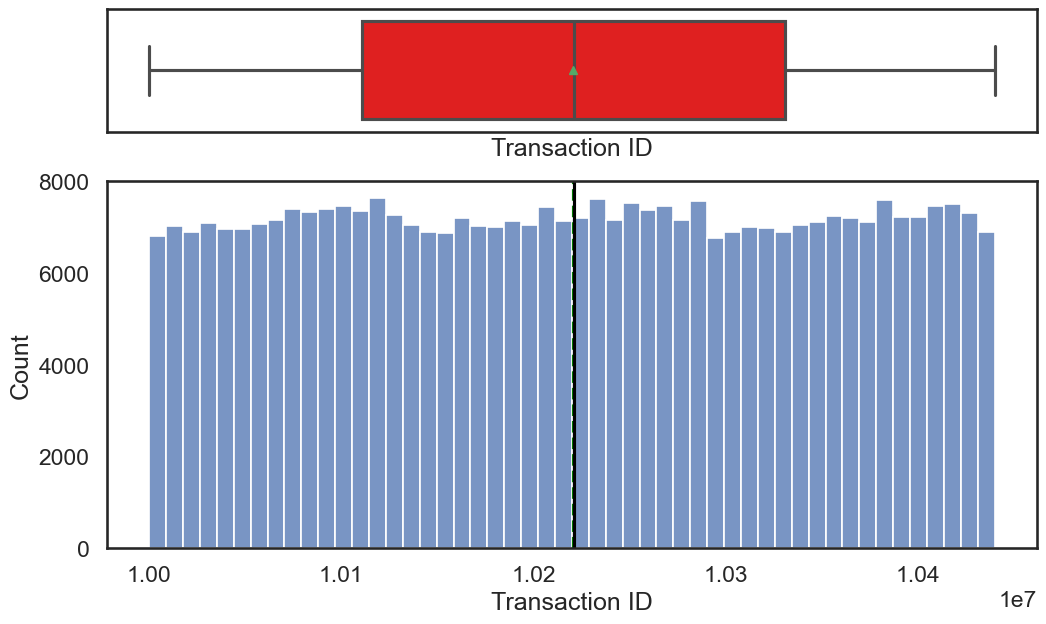

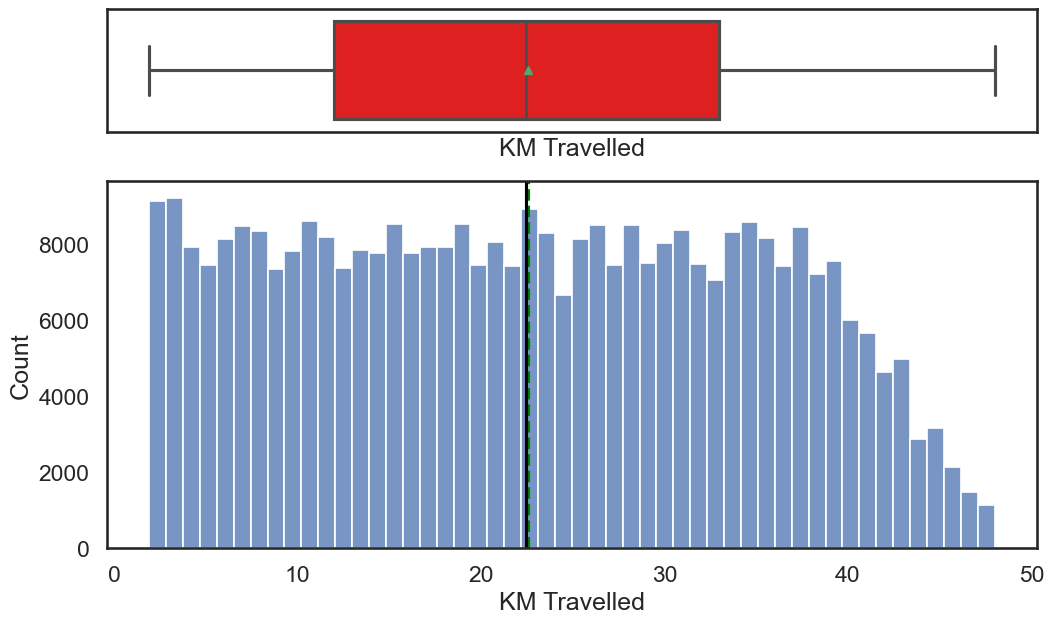

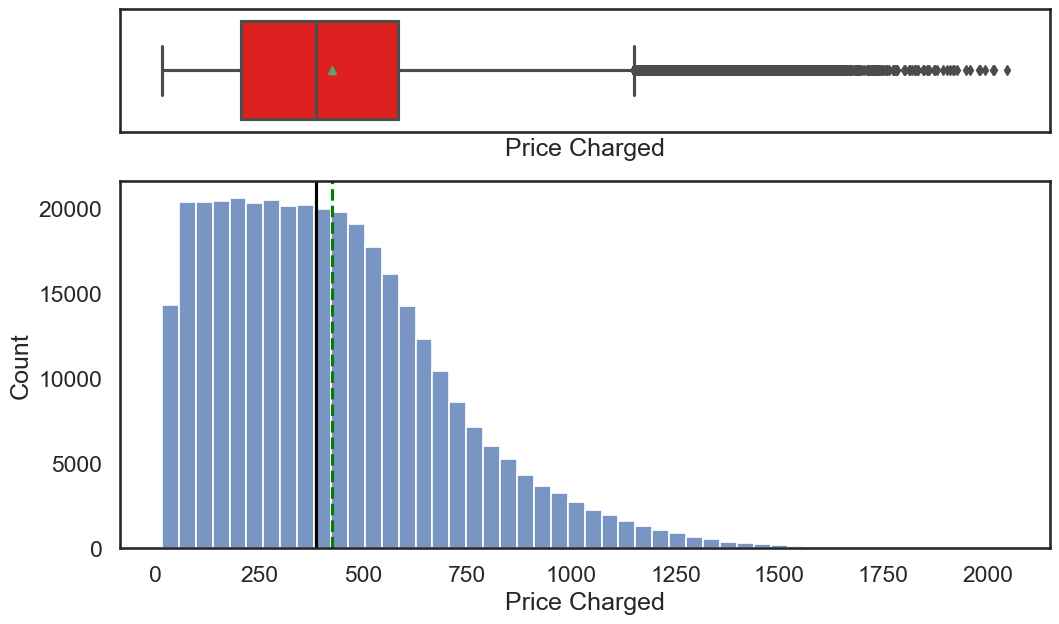

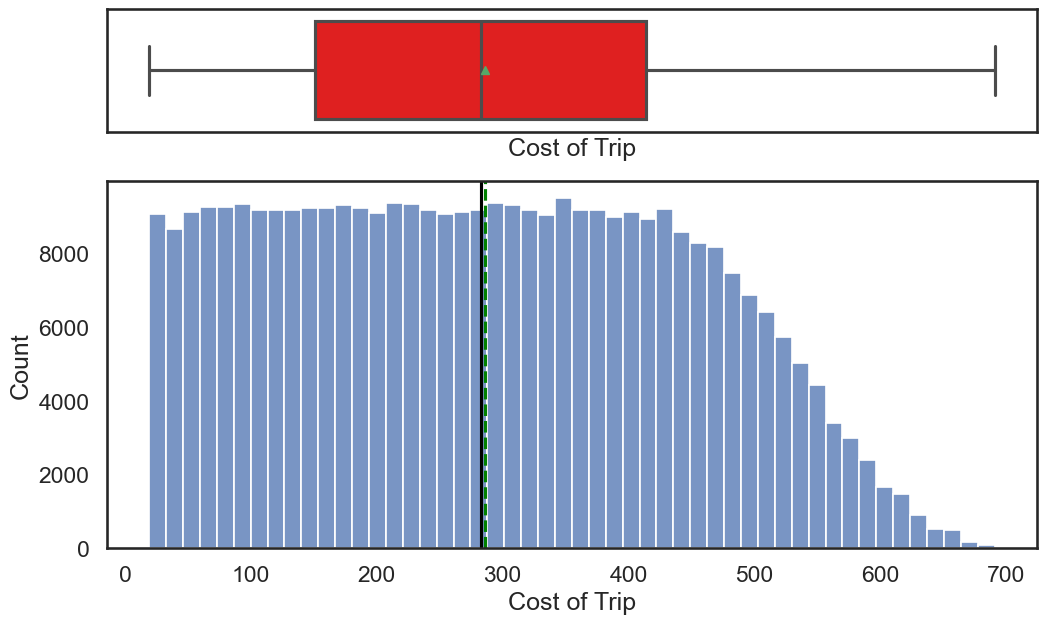

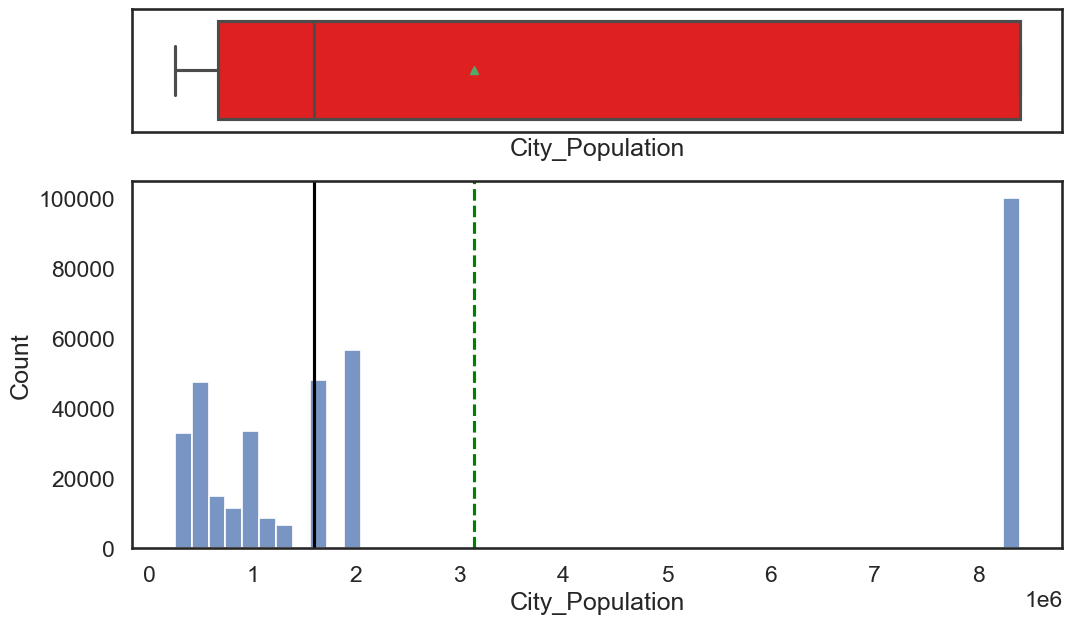

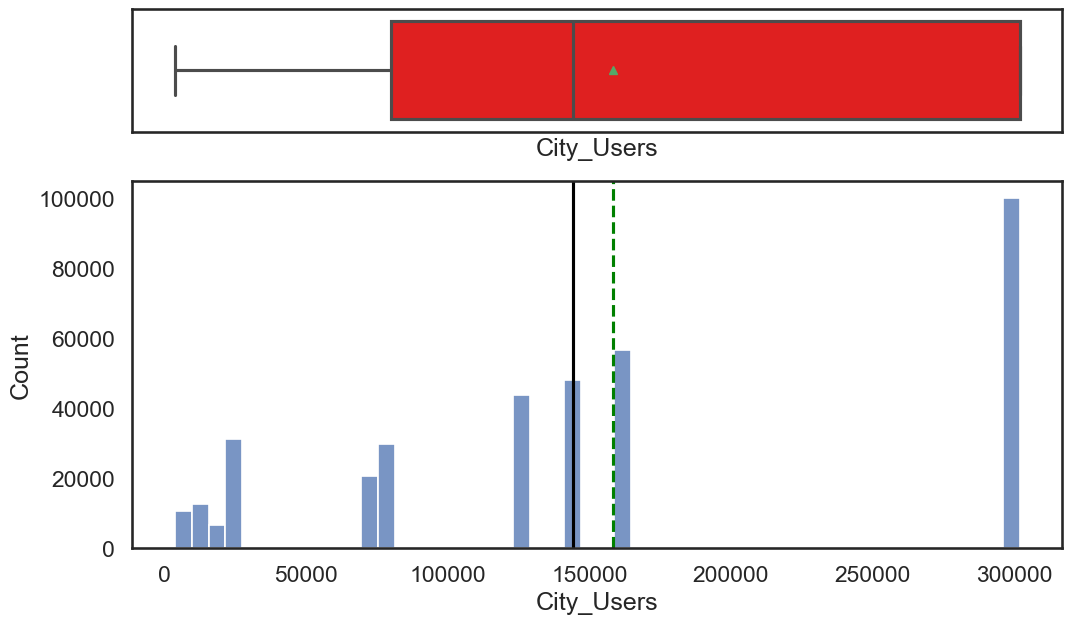

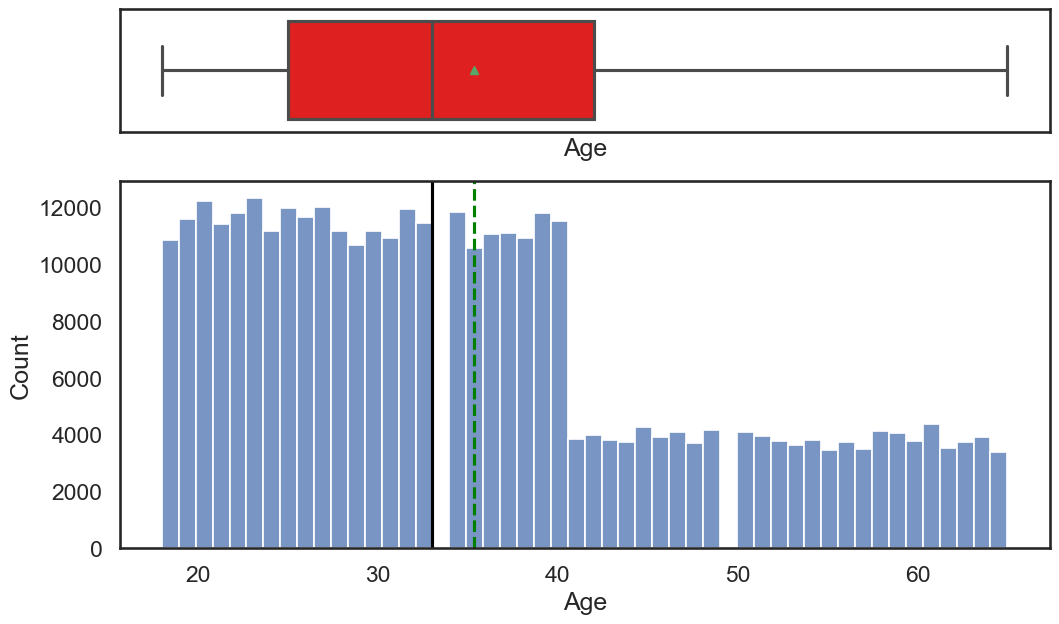

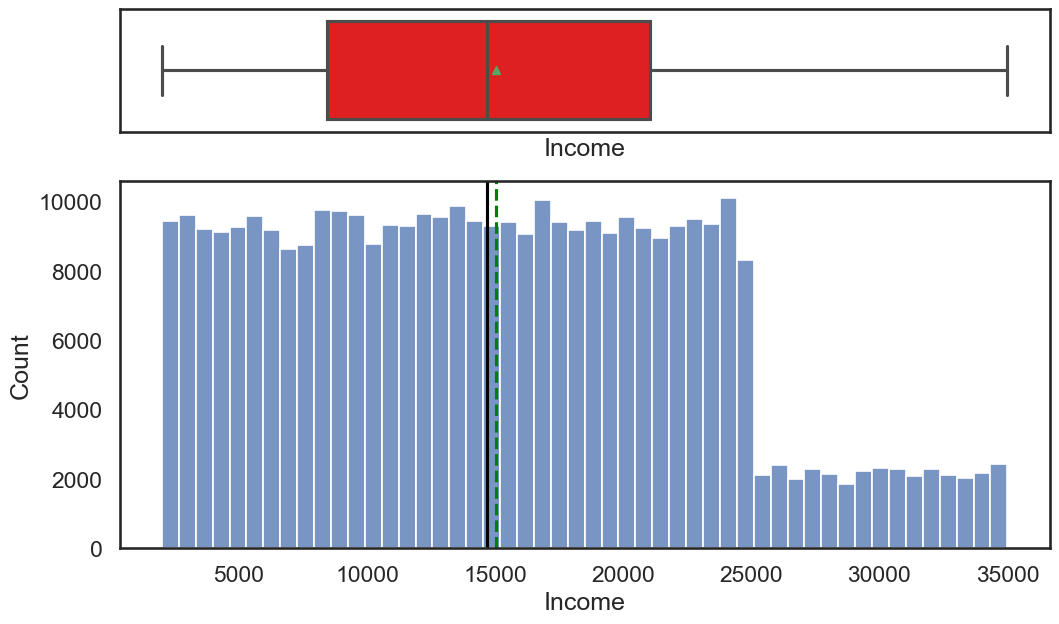

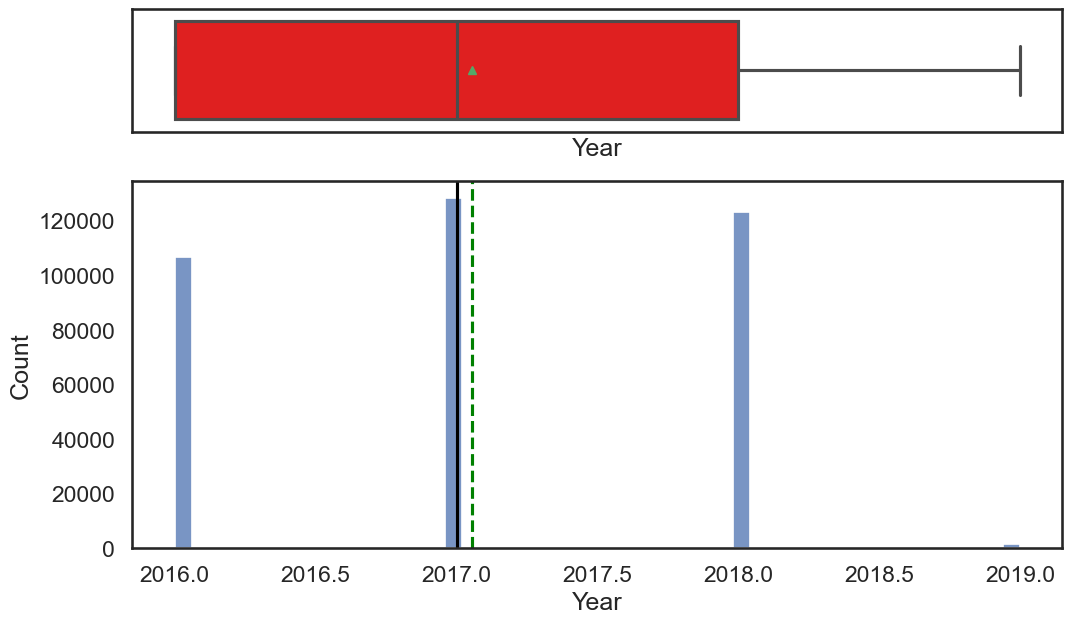

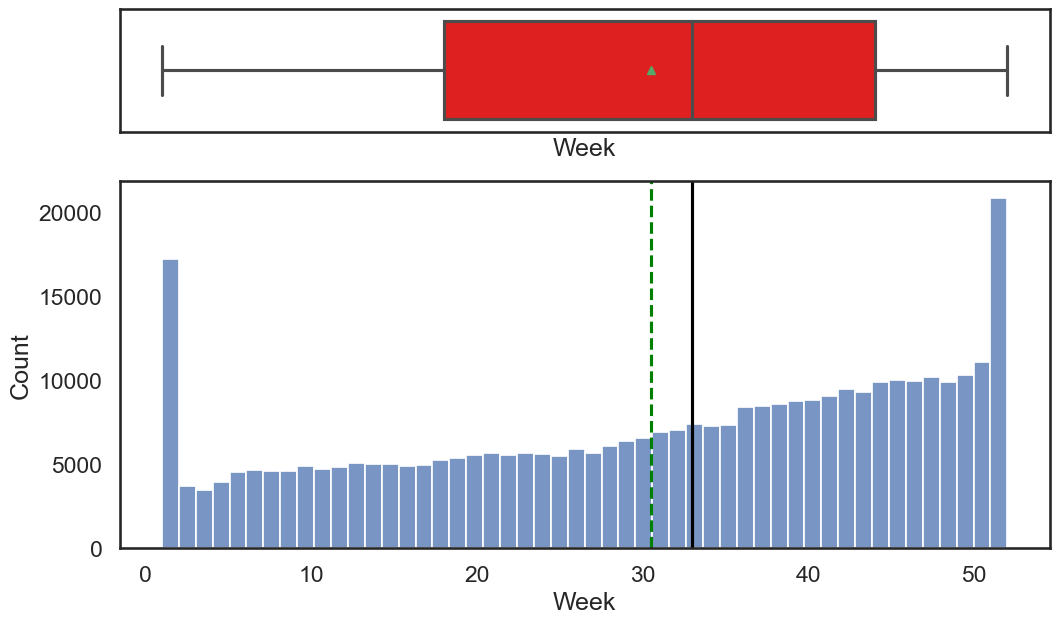

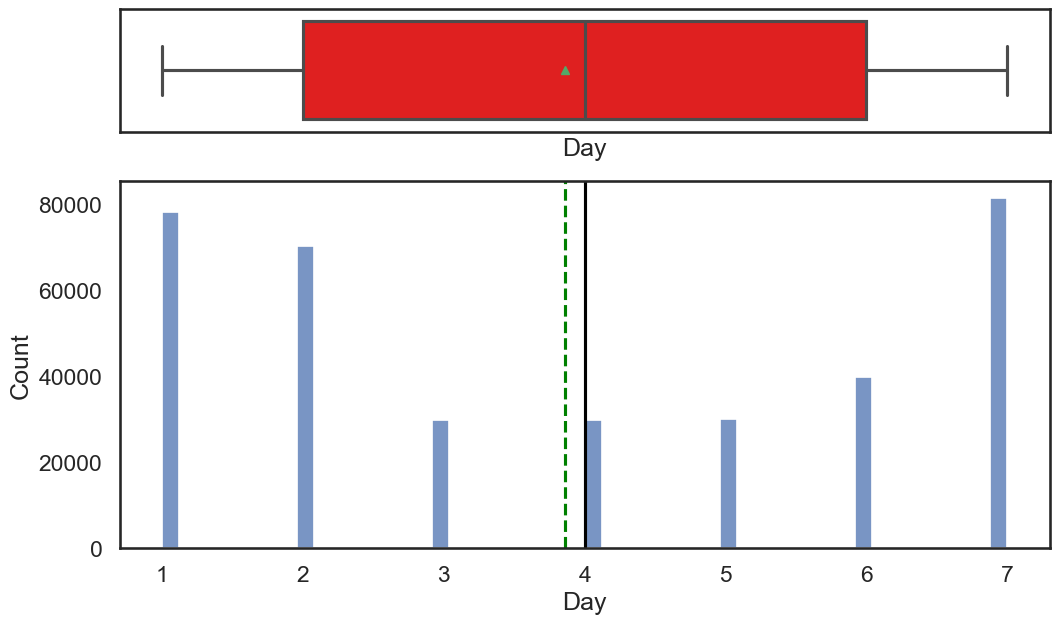

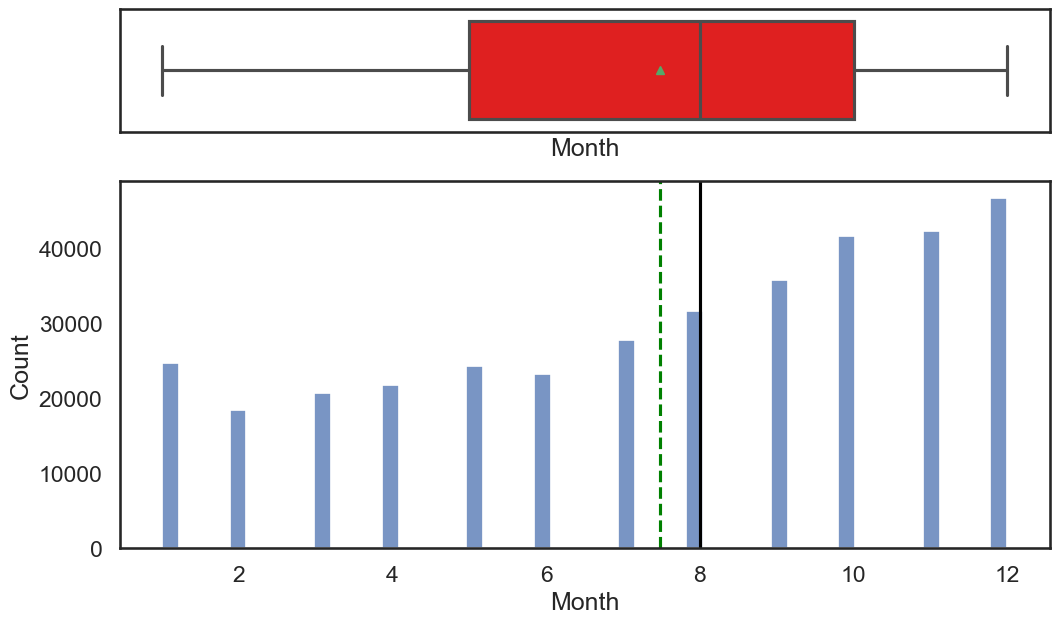

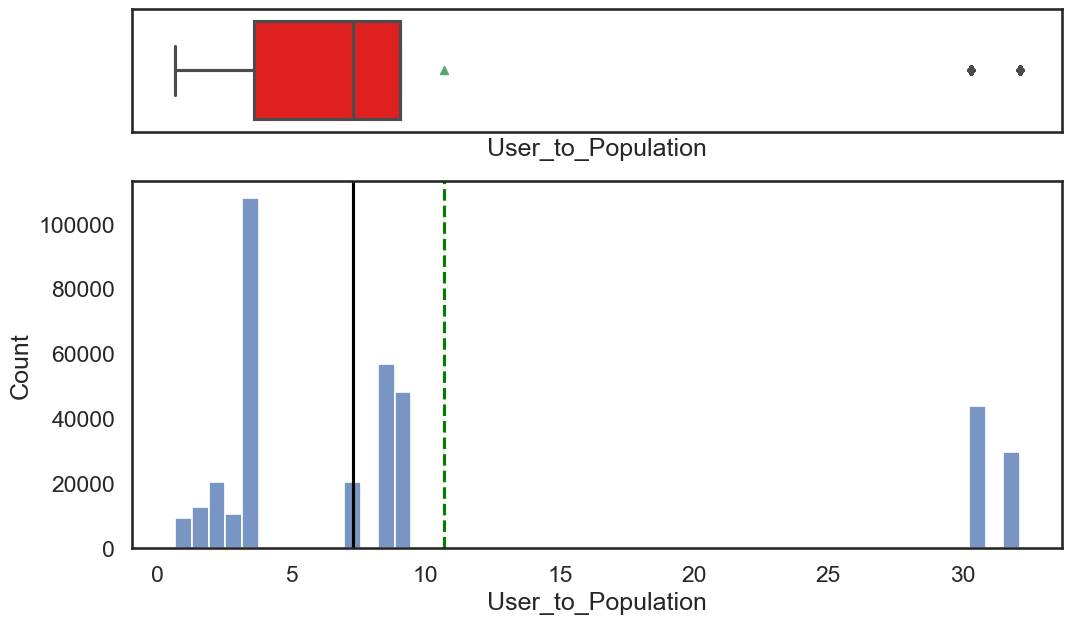

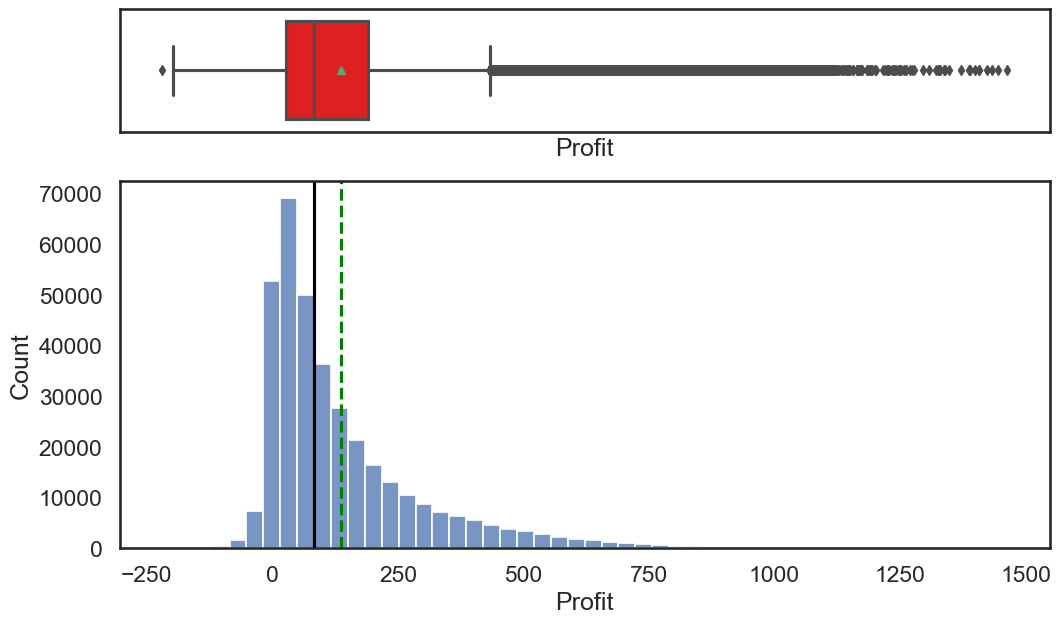

In [147]:
for col in data.select_dtypes('number').columns.tolist():

    histogram_boxplot(data,col,bins=50)

### Observation:
* On average the km Travelled is 22 km   
* Average Price charged in 350 and median 400 while the Cost of Trip has equal average and median 300.   
* The Age average is 33 while the median 36.Yong users more likely to use the Cab.   
* user with income less than 25000 more likely to use the Cab than users gaining more than 25000.   



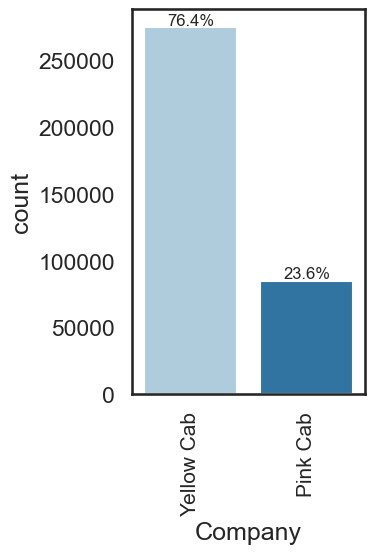

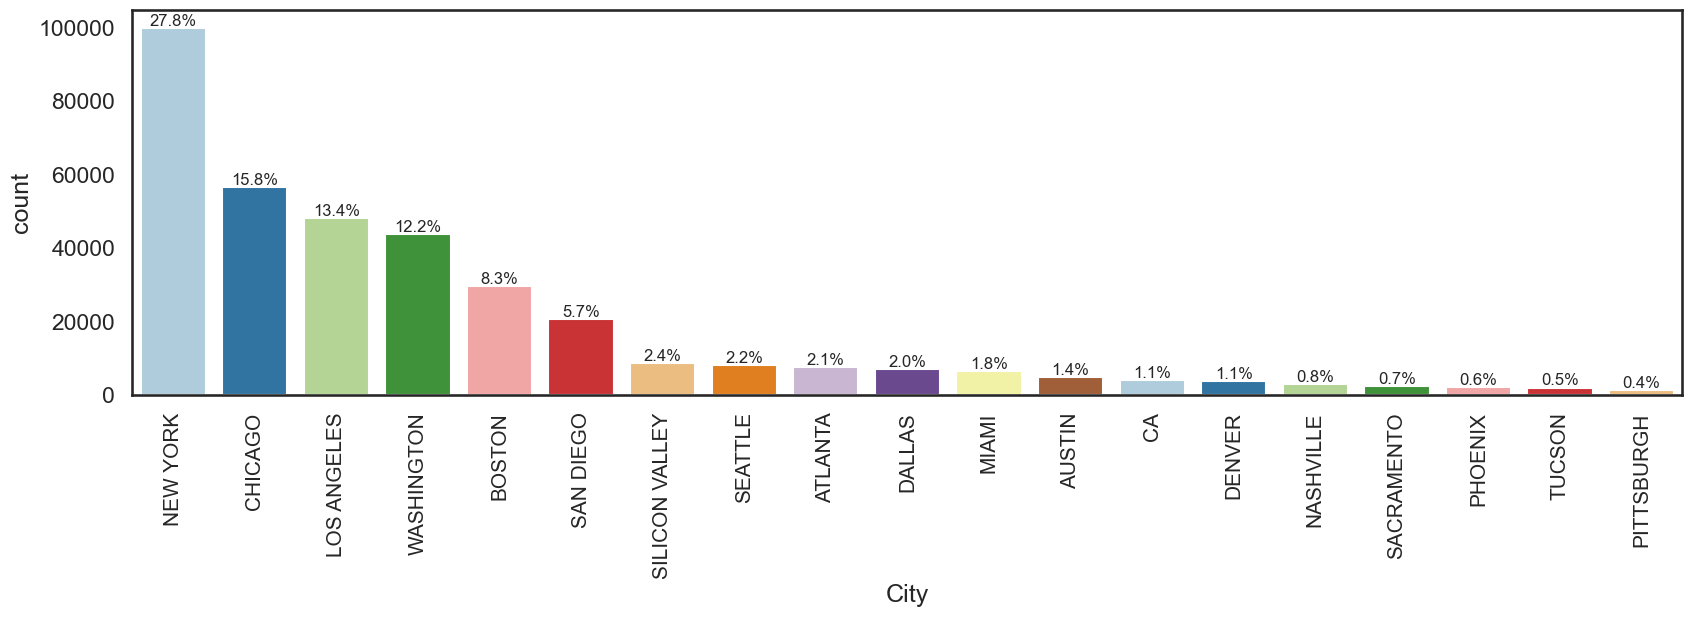

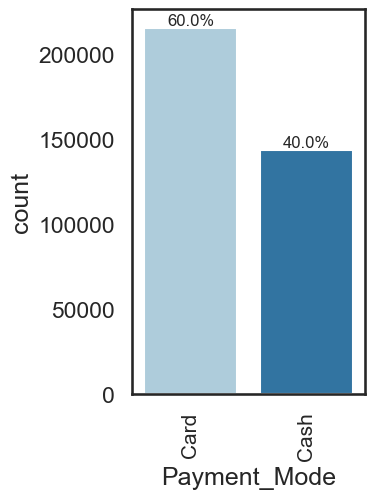

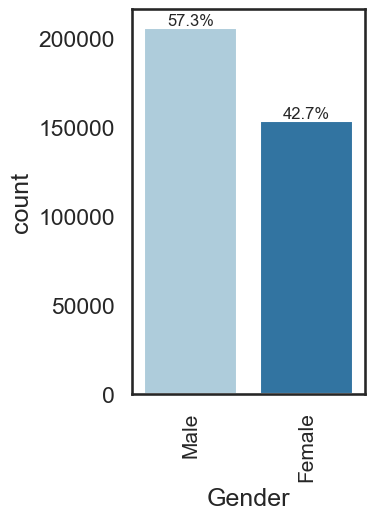

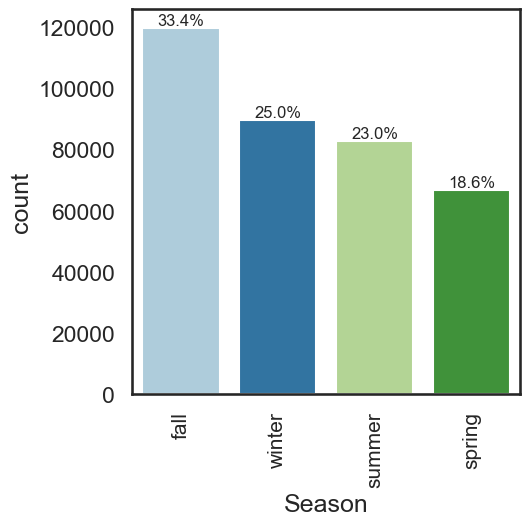

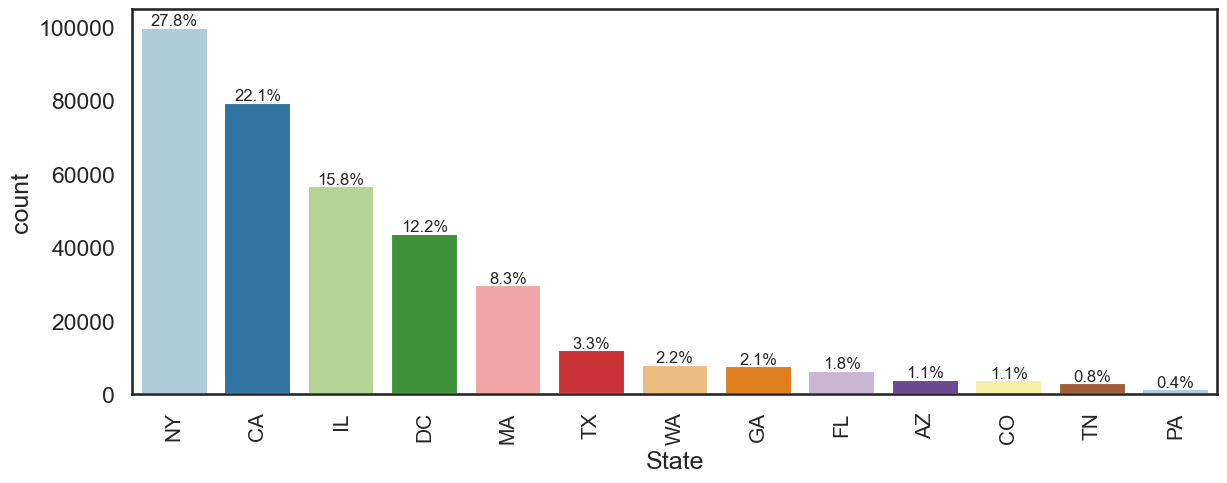

In [148]:
for col in data.select_dtypes('object').columns.tolist():
    labeled_barplot(data,col)


### Observation 
* 76% of the users used Yellow Cab while 23% used Pink Cab.   
* New Your has the highest user number then Chicago.  
* 60% of user pay by Card.   
* 57% of the users are male and 42% are female.
* 33% of the orders happened in fall season.   

Gender      Female    Male     All
Company                           
All         153480  205912  359392
Yellow Cab  116000  158681  274681
Pink Cab     37480   47231   84711
------------------------------------------------------------------------------------------------------------------------


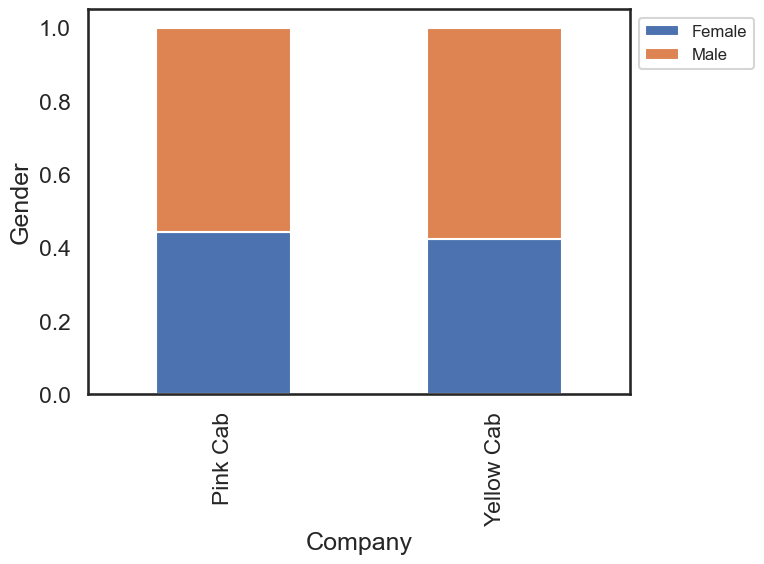

In [149]:
stacked_barplot(data,'Company','Gender')

Payment_Mode    Card    Cash     All
Company                             
All           215504  143888  359392
Yellow Cab    164785  109896  274681
Pink Cab       50719   33992   84711
------------------------------------------------------------------------------------------------------------------------


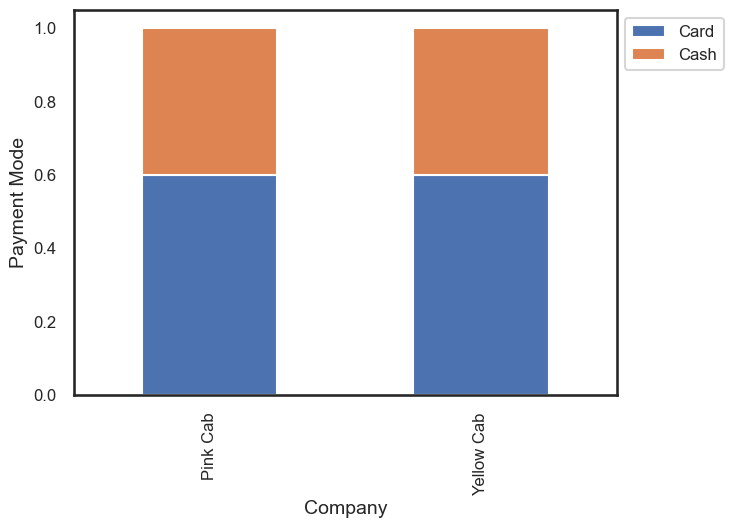

In [150]:
stacked_barplot(data,'Company','Payment_Mode')

City        ATLANTA  AUSTIN  BOSTON    CA  CHICAGO  DALLAS  DENVER  \
Company                                                              
All            7557    4896   29692  3982    56625    7017    3825   
Pink Cab       1762    1868    5186  1513     9361    1380    1394   
Yellow Cab     5795    3028   24506  2469    47264    5637    2431   

City        LOS ANGELES  MIAMI  NASHVILLE  NEW YORK  PHOENIX  PITTSBURGH  \
Company                                                                    
All               48033   6454       3010     99885     2064        1313   
Pink Cab          19865   2002       1841     13967      864         682   
Yellow Cab        28168   4452       1169     85918     1200         631   

City        SACRAMENTO  SAN DIEGO  SEATTLE  SILICON VALLEY  TUCSON  \
Company                                                              
All               2367      20488     7997            8519    1931   
Pink Cab          1334      10672     2732            3797

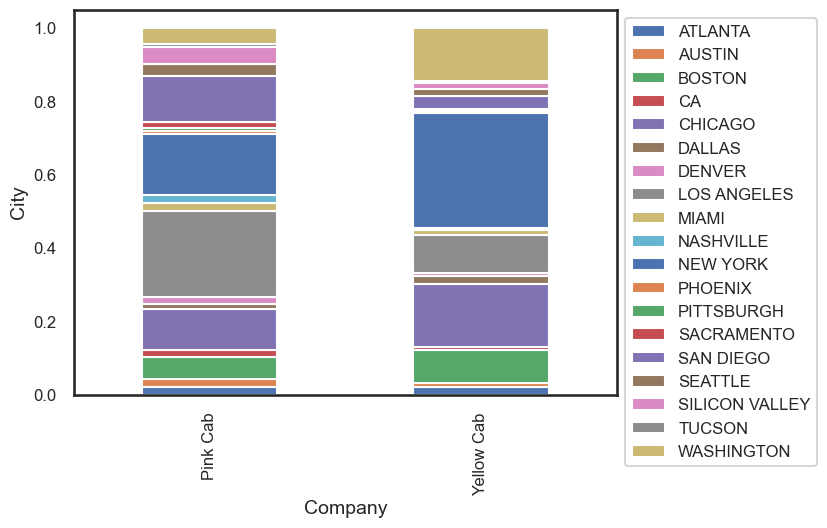

In [151]:
stacked_barplot(data,'Company','City')

State         AZ     CA    CO     DC    FL    GA     IL     MA     NY    PA  \
Company                                                                       
All         3995  79407  3825  43737  6454  7557  56625  29692  99885  1313   
Pink Cab    1663  35668  1394   3692  2002  1762   9361   5186  13967   682   
Yellow Cab  2332  43739  2431  40045  4452  5795  47264  24506  85918   631   

State         TN     TX    WA     All  
Company                                
All         3010  11913  7997  355410  
Pink Cab    1841   3248  2732   83198  
Yellow Cab  1169   8665  5265  272212  
------------------------------------------------------------------------------------------------------------------------


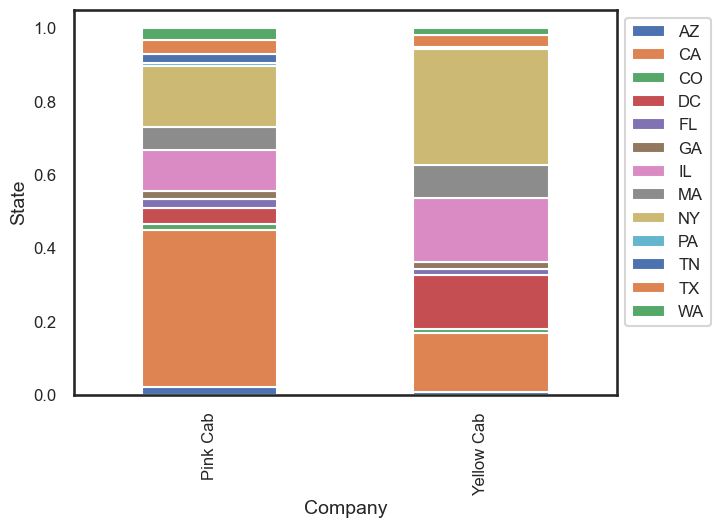

In [152]:
stacked_barplot(data,'Company','State')

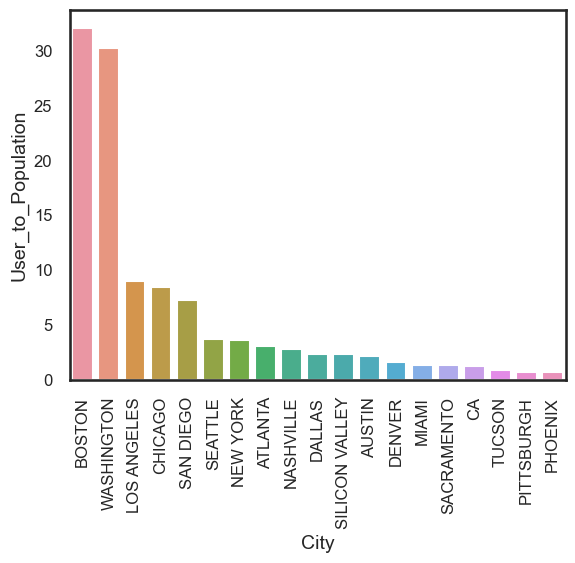

In [153]:
sns.barplot(data=data,x='City',y='User_to_Population'
            ,order=data.groupby('City').mean()['User_to_Population'].sort_values(ascending=False).index.tolist())
plt.xticks(rotation=90);

### Observation 
* For the two companies, ratio of the male to female users are the same.  
*  For the two companies, ratio of the card to cash users are the same.
* for the two companies, the users are spread differently over the cities. e.g. Yellow companies has more users in New York than pink company while in Los AnGeles pink company has more users.    
* Pink Cab exist more in Texas, Arizona, and Colorado while Yellow cab exist in New york, IL, and DC.   
* Boston, Washington, and Los Angeles have the higher values of users to population. 


## Outliers

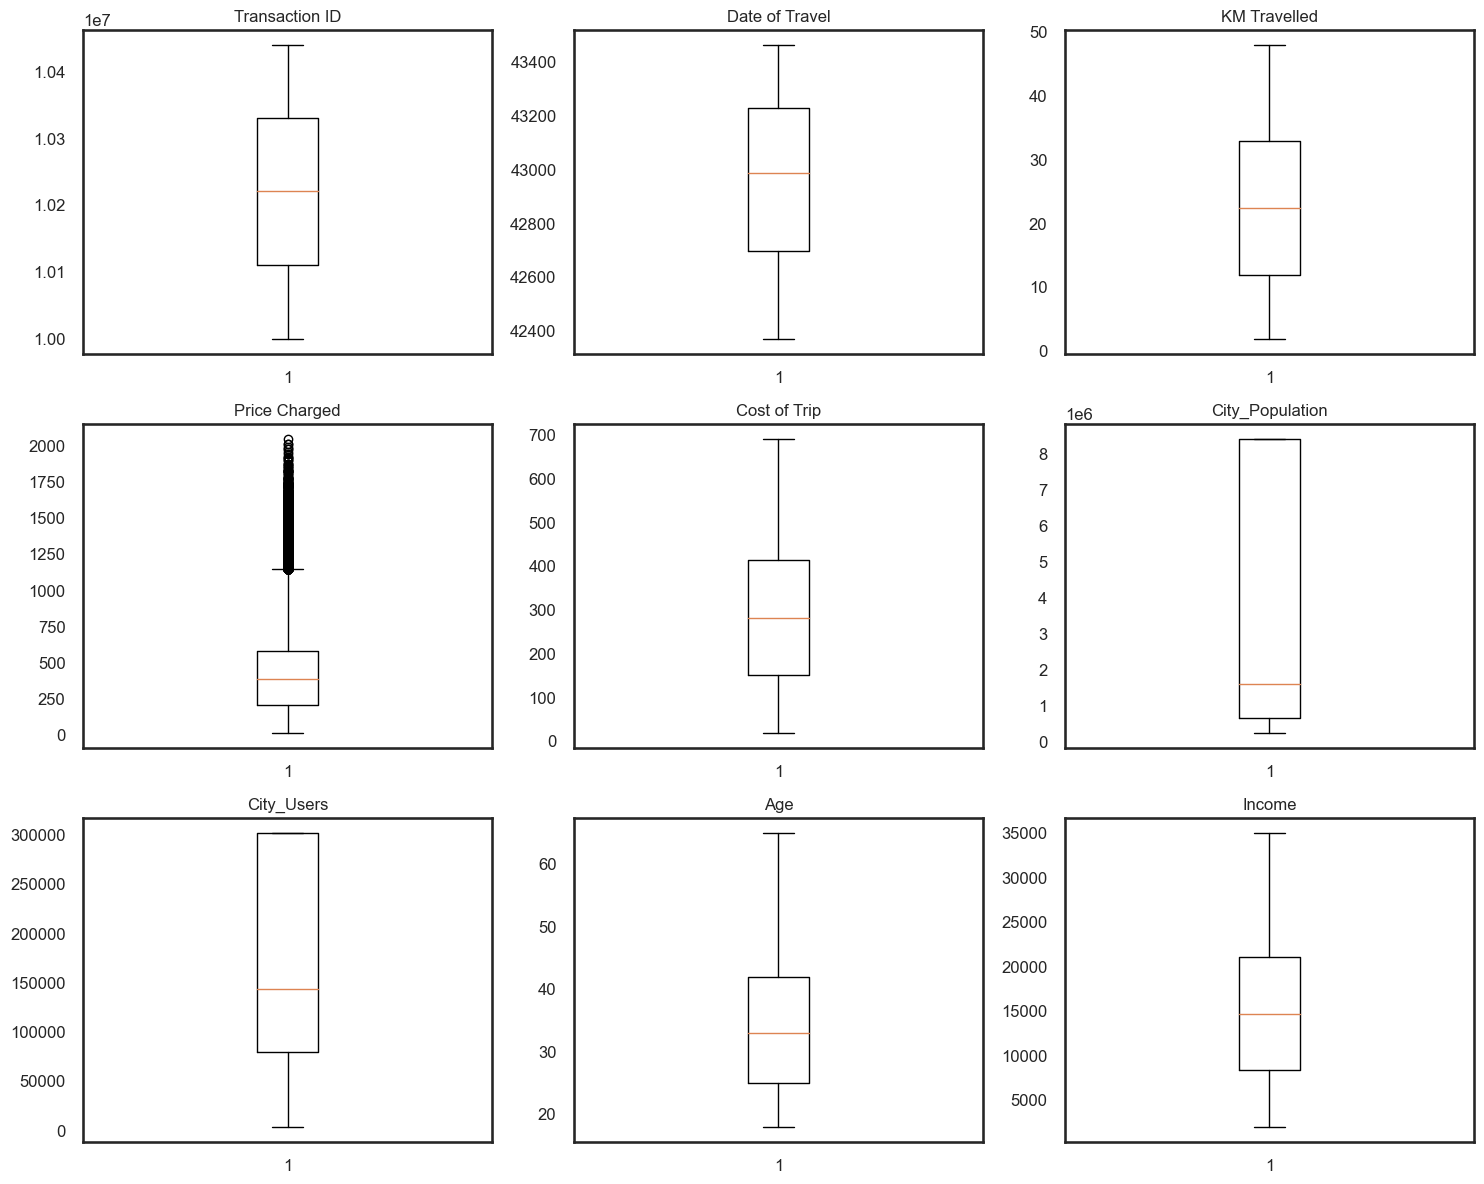

In [154]:
plt.figure(figsize=(15, 12))

numeric_columns = df.select_dtypes(include='number').columns.tolist()

for i, variable in enumerate(numeric_columns):
    plt.subplot(3, 3, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)
plt.savefig('outliers.png')
plt.show()

Obs: No outliers in the datasets

### Multivariant Analysis 
the goal to track how the bivariant analysis of the two companies change with gender, City, and State

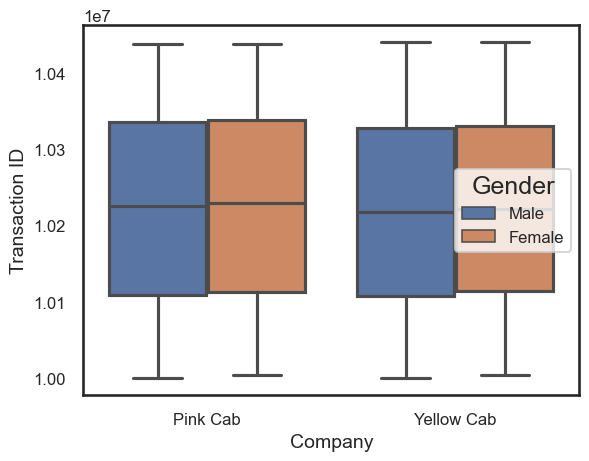

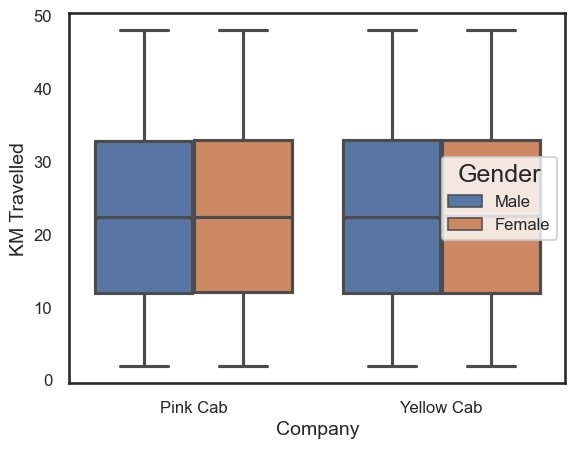

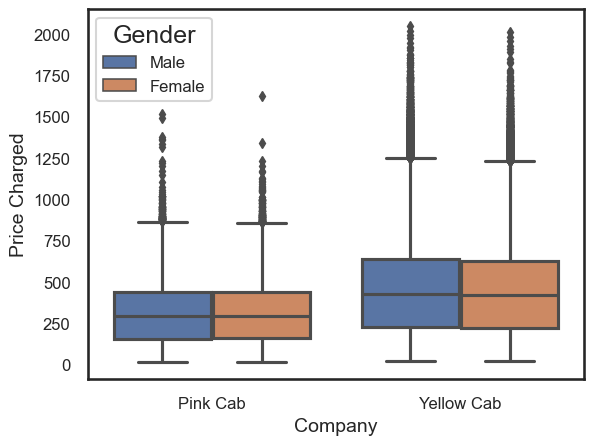

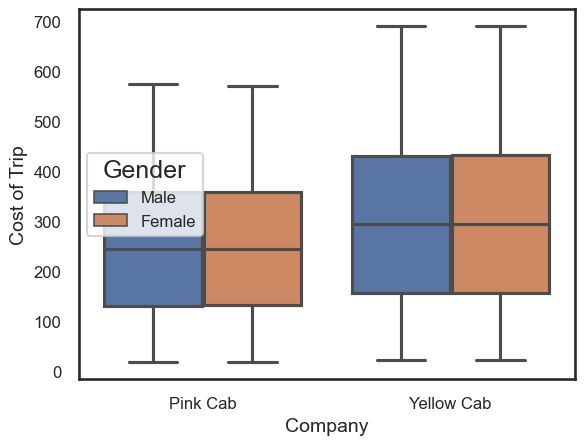

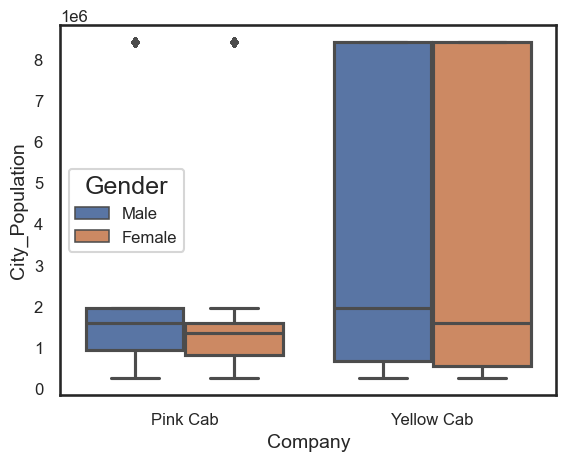

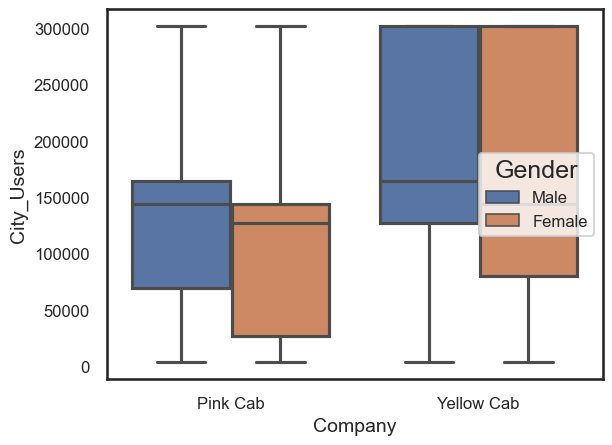

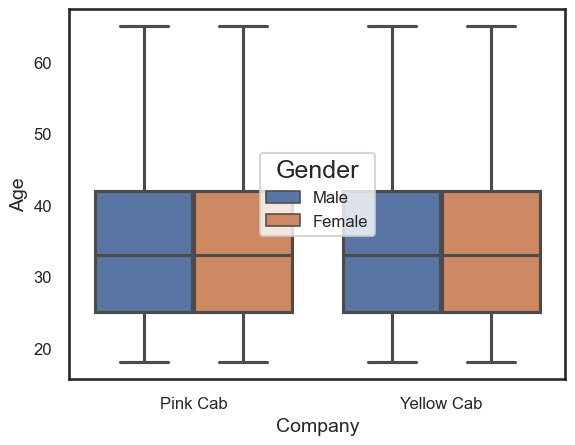

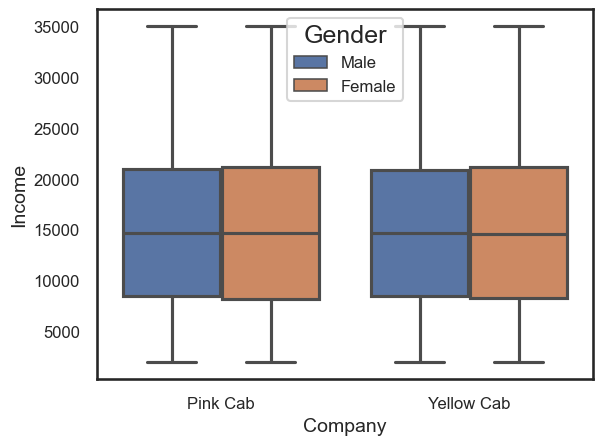

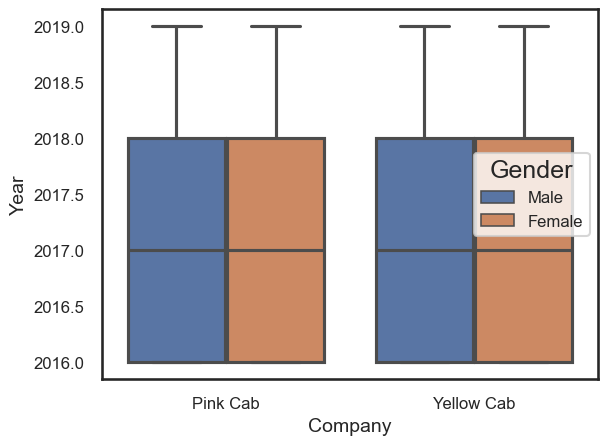

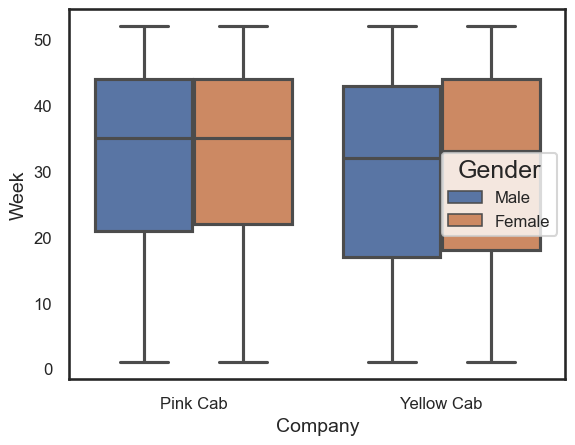

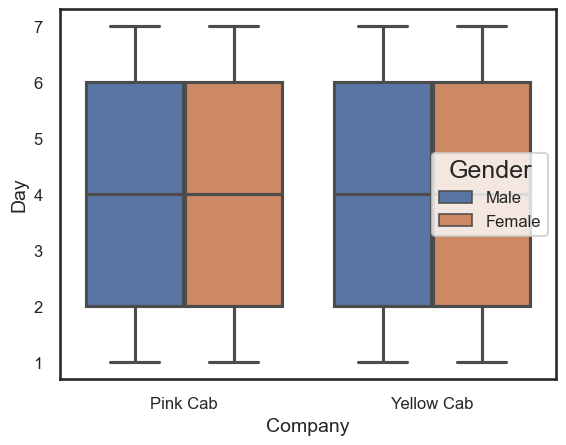

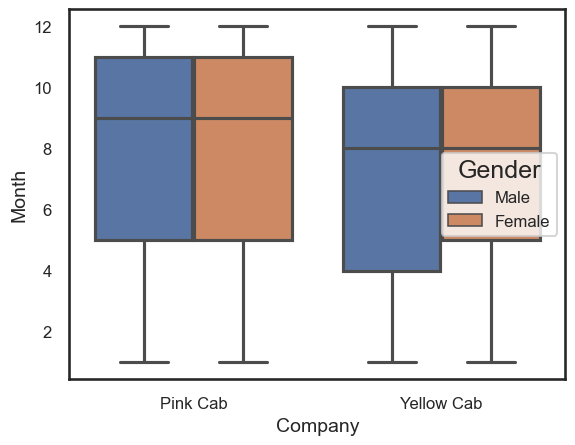

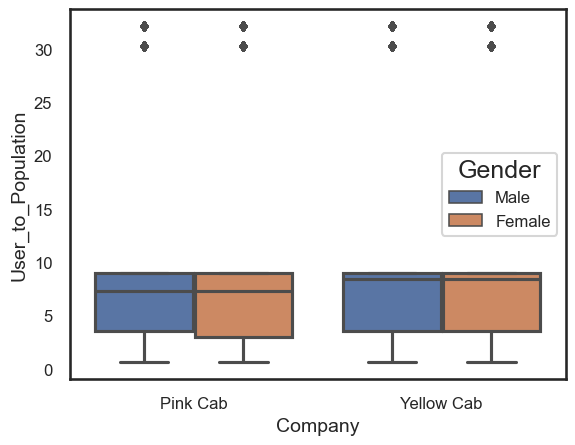

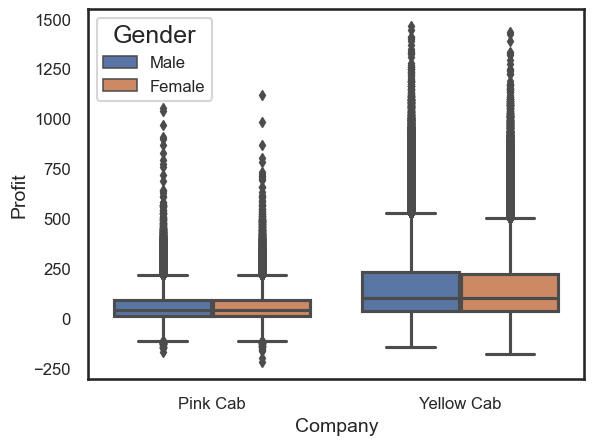

In [155]:
for col in data.select_dtypes(include='number').columns.tolist():
    plt.figure()
    sns.boxplot(data=data,x='Company',y=col,hue='Gender')

### Observation 
* there is no Gender effect on Traveling Km for each company.
* The Yellow Cab has higer cost of trip and has charged higher prices however there is no effect for gender.
* Yellow Cab exists in city with wide range in population and it has higher population median than the pink cab. Gender has effect on the city population where men shows higher population median than women. 
* Both companies has the same average Age, and income.
* The ratio of user to population in each cith is higher for Yellow cab. than pick cab. that mean Yellow cab exists in city with more users than Pink cab. 
* Yellow cab made much more profit than Pink cab.    

# The Date Time Analysis.
The goal is to track the trend of the two company over the time and explore the data regrading the week days, months, and seasons.  

(array([16801., 16922., 17045., 17167., 17287., 17410., 17532., 17652.,
        17775., 17897.]),
 [Text(16801.0, 0, '2016-01'),
  Text(16922.0, 0, '2016-05'),
  Text(17045.0, 0, '2016-09'),
  Text(17167.0, 0, '2017-01'),
  Text(17287.0, 0, '2017-05'),
  Text(17410.0, 0, '2017-09'),
  Text(17532.0, 0, '2018-01'),
  Text(17652.0, 0, '2018-05'),
  Text(17775.0, 0, '2018-09'),
  Text(17897.0, 0, '2019-01')])

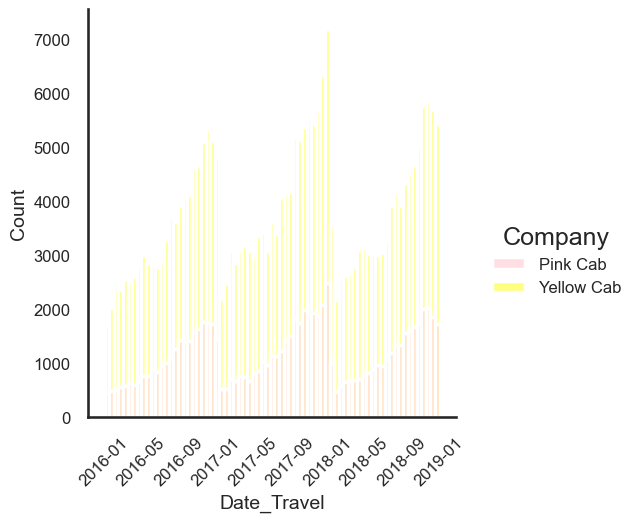

In [156]:
sns.displot(data=data,x='Date_Travel'
             ,hue='Company',palette=["pink", "yellow"], linewidth=2.5)
plt.xticks(rotation=45,fontsize=12)

(array([16801., 16922., 17045., 17167., 17287., 17410., 17532., 17652.,
        17775., 17897.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

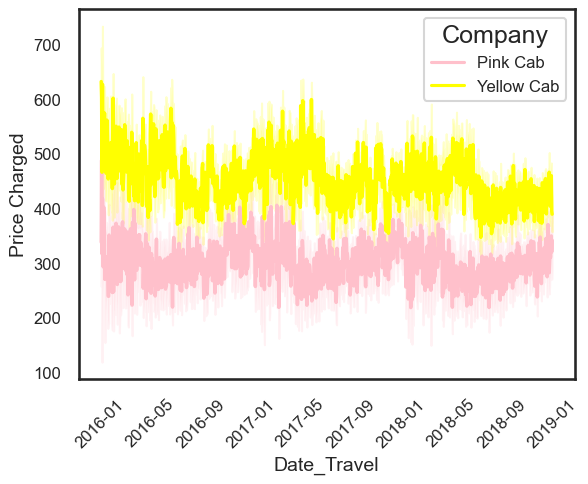

In [157]:

sns.lineplot(data=data,x='Date_Travel',y='Price Charged'
             ,hue='Company',palette=["pink", "yellow"], linewidth=2.5)
plt.xticks(rotation=45,fontsize=12)

(array([16801., 16922., 17045., 17167., 17287., 17410., 17532., 17652.,
        17775., 17897.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

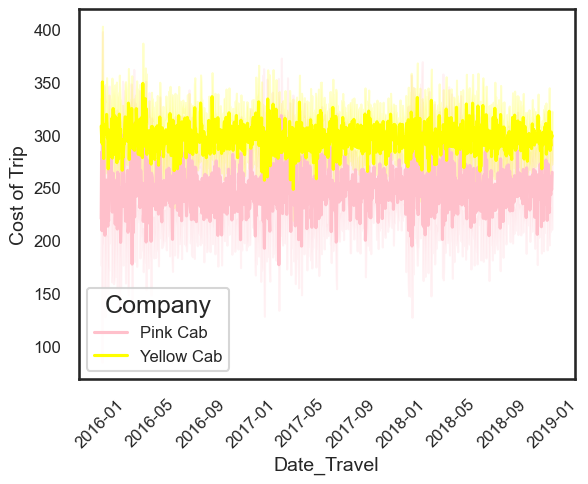

In [158]:
sns.lineplot(data=data,x='Date_Travel',y='Cost of Trip',
             hue='Company',palette=["pink", "yellow"])
plt.xticks(rotation=45,fontsize=12)

<AxesSubplot:xlabel='Season', ylabel='Profit'>

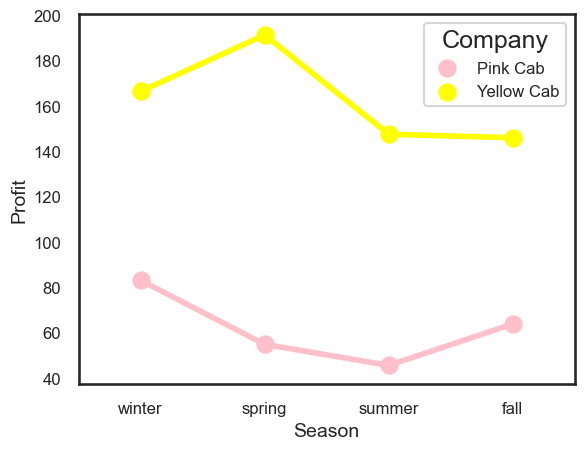

In [159]:
sns.pointplot(data=data,x='Season',y='Profit',hue='Company',palette=["pink", "yellow"],order=['winter','spring','summer','fall'])

<AxesSubplot:xlabel='Month', ylabel='Profit'>

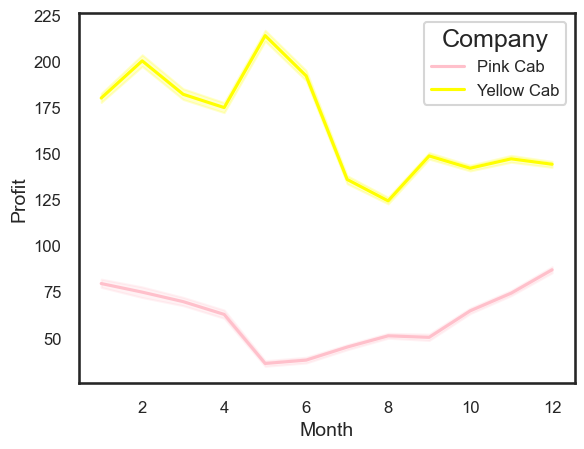

In [160]:
sns.lineplot(data=data,x='Month',y=data['Profit']
             ,hue='Company',palette=["pink", "yellow"])


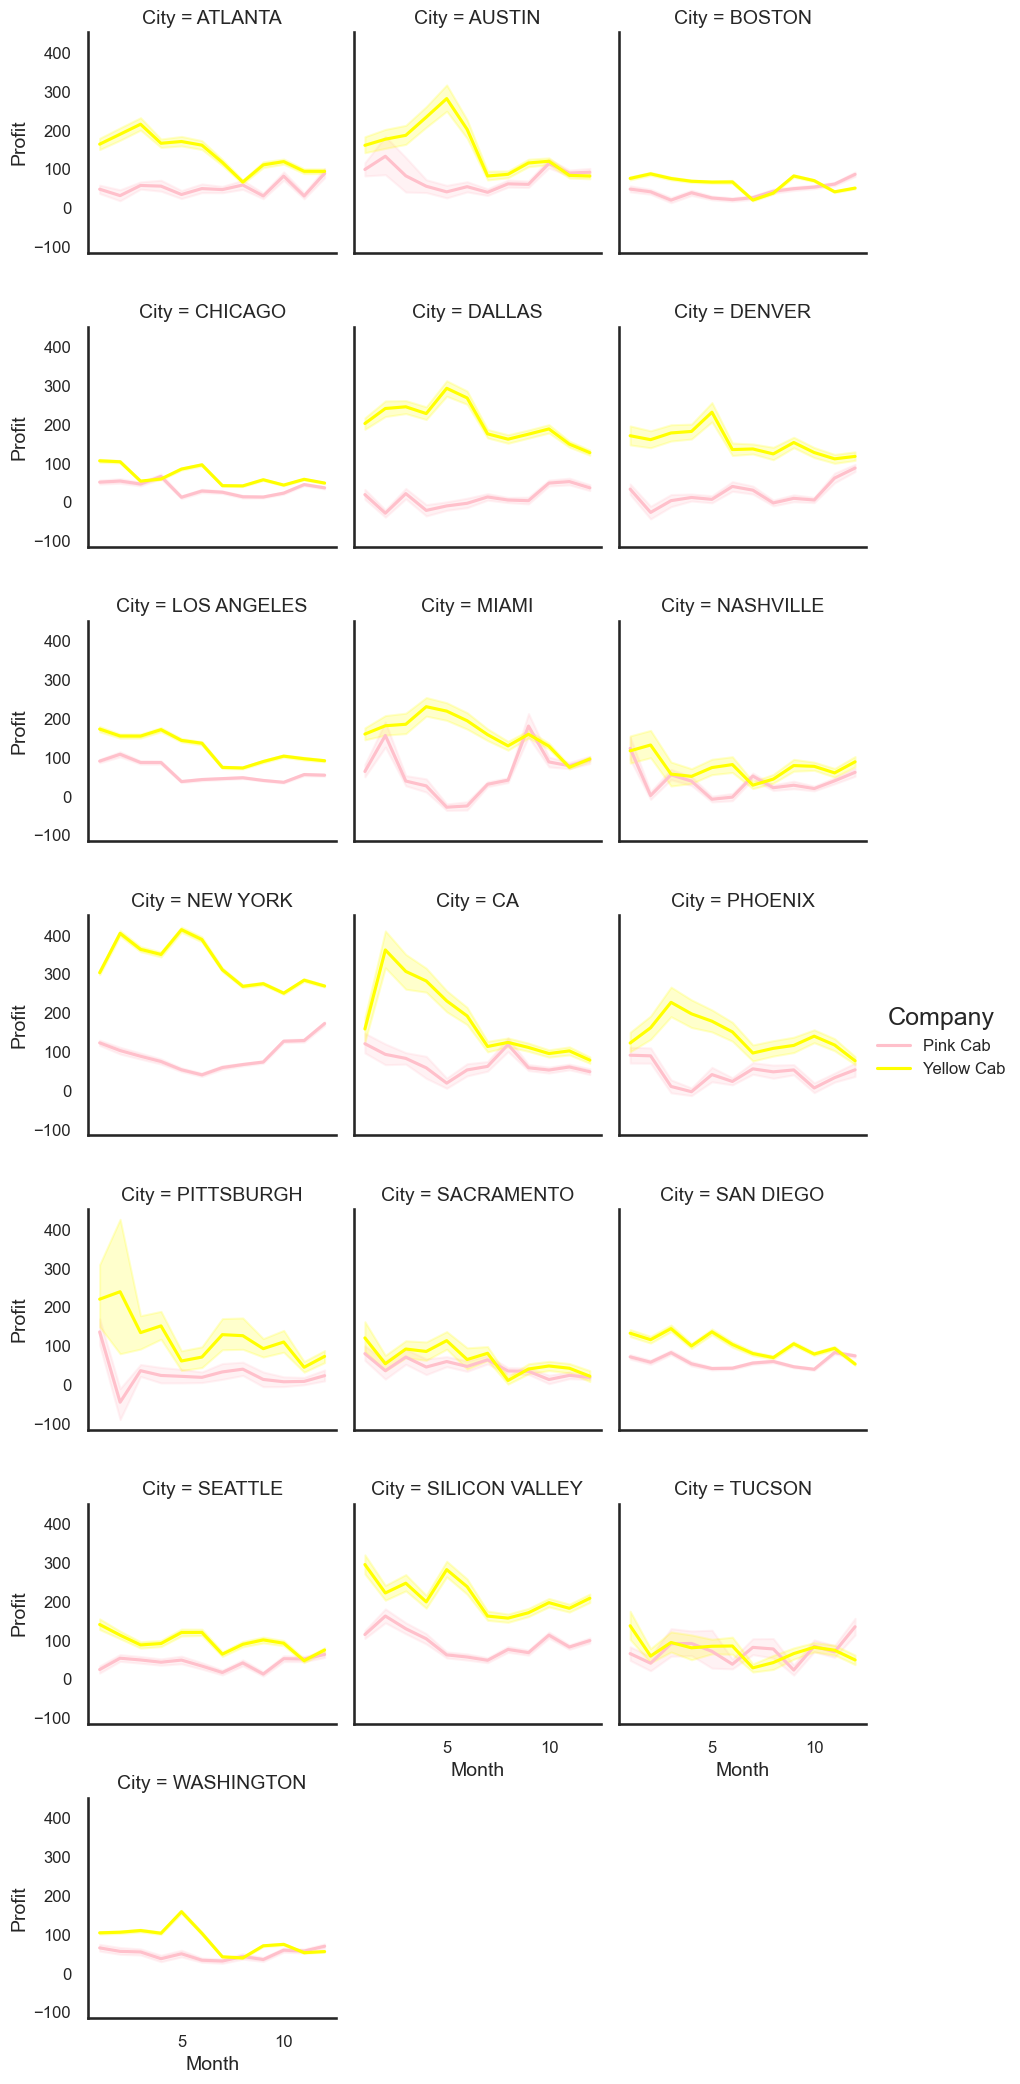

In [161]:
g = sns.FacetGrid(data=data,hue='Company',col='City',col_wrap=3,palette=["pink", "yellow"])
g.map(sns.lineplot, 'Month', 'Profit')
g.add_legend()

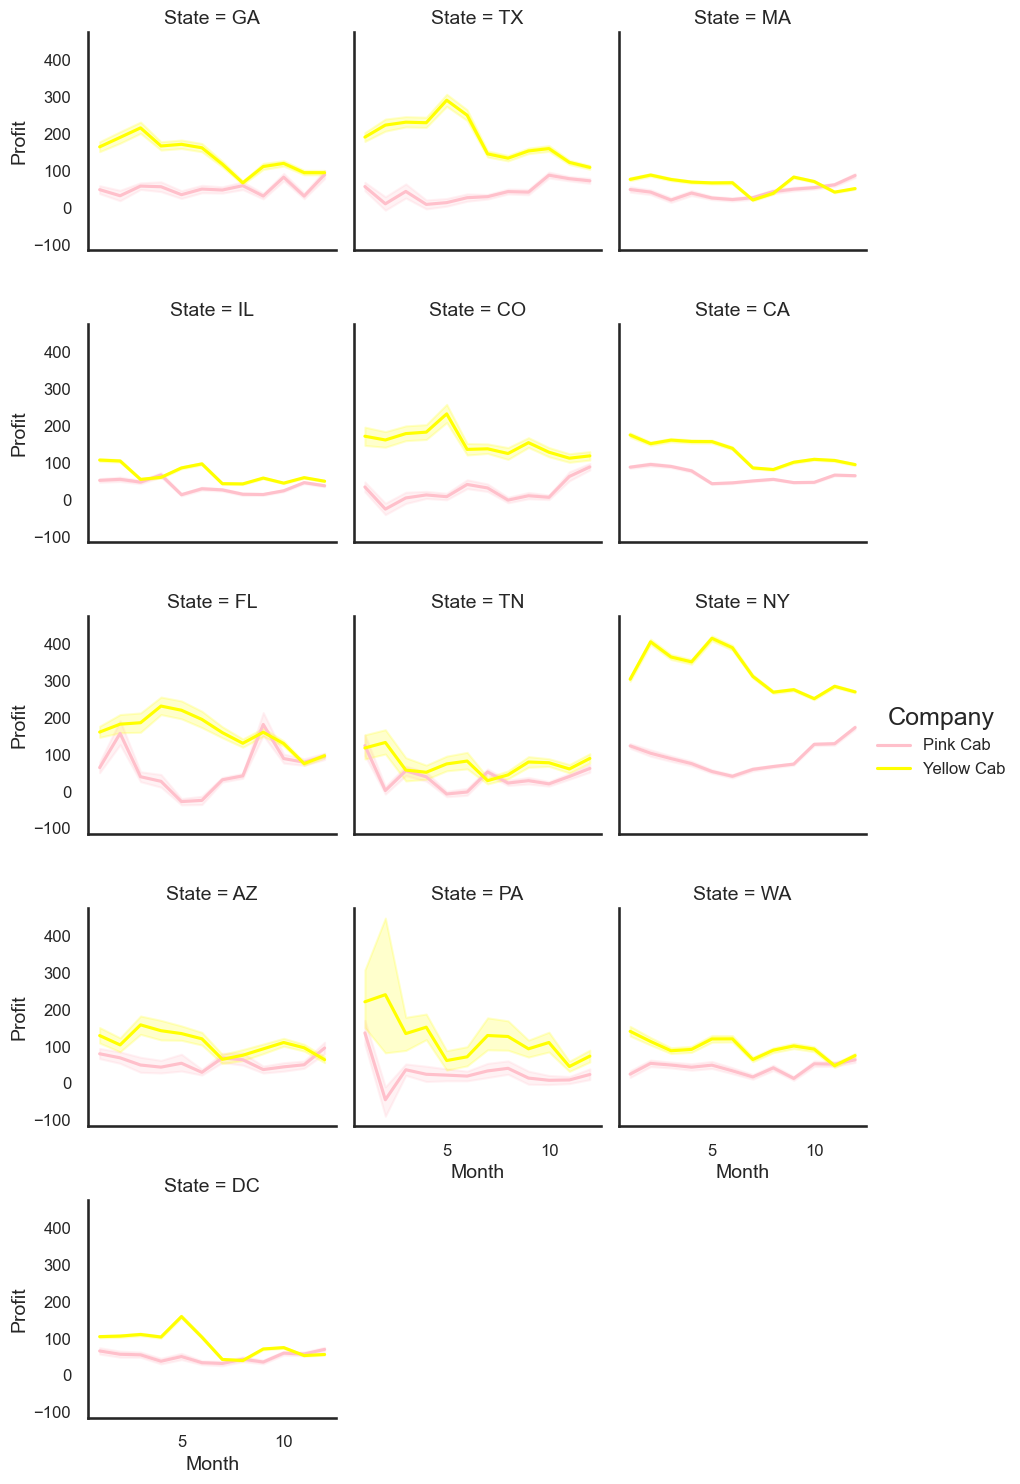

In [162]:
g = sns.FacetGrid(data=data,hue='Company',col='State',col_wrap=3,palette=["pink", "yellow"])
g.map(sns.lineplot, 'Month', 'Profit')
g.add_legend()

<AxesSubplot:xlabel='Day', ylabel='Profit'>

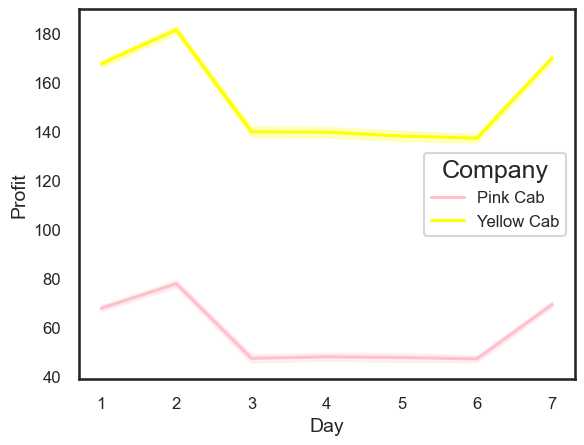

In [163]:
sns.lineplot(data=data,x='Day',y='Profit',hue='Company',palette=["pink", "yellow"])


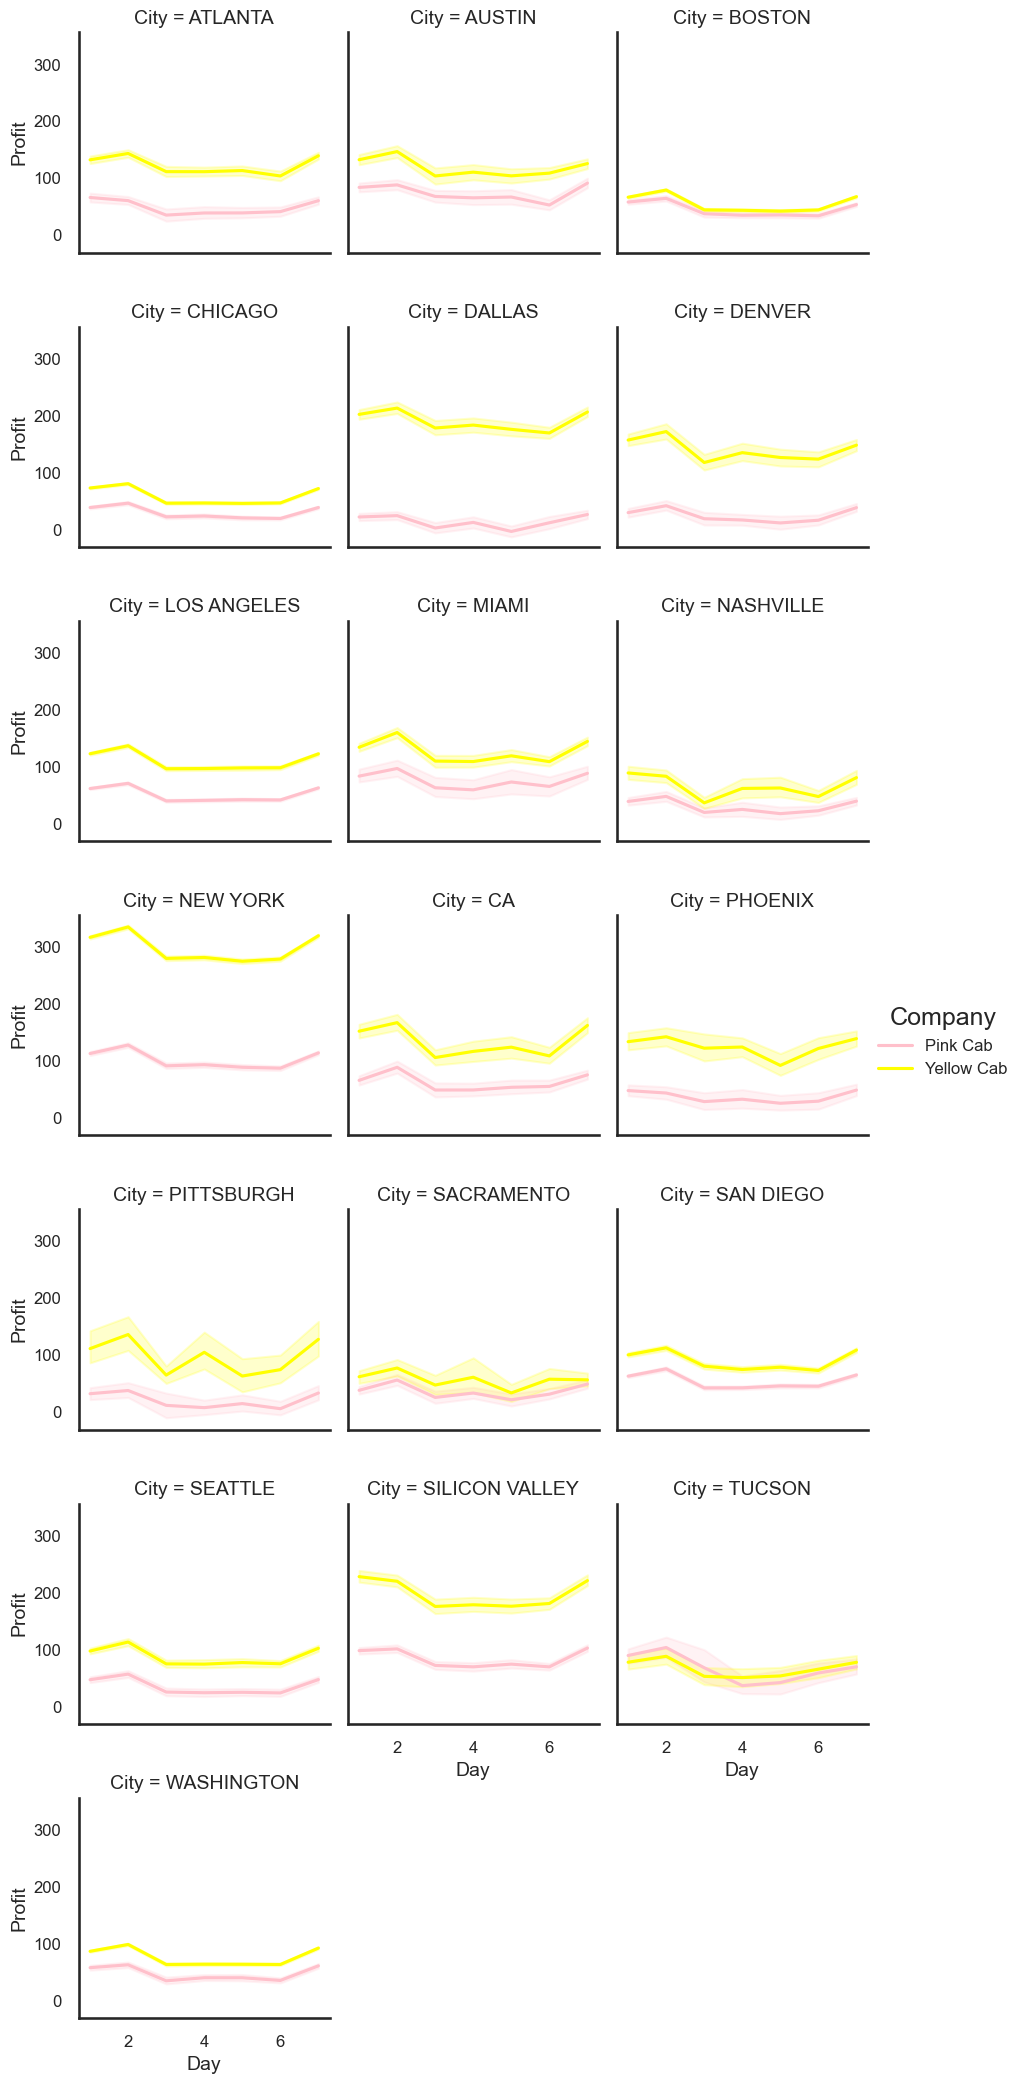

In [164]:
g = sns.FacetGrid(data=data,hue='Company',col='City',col_wrap=3,palette=["pink", "yellow"])
g.map(sns.lineplot, 'Day', 'Profit')
g.add_legend()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, '3643'),
  Text(1, 0, '5712'),
  Text(2, 0, '6133'),
  Text(3, 0, '7044'),
  Text(4, 0, '9270'),
  Text(5, 0, '12421'),
  Text(6, 0, '12994'),
  Text(7, 0, '14978'),
  Text(8, 0, '17675'),
  Text(9, 0, '22157'),
  Text(10, 0, '24701'),
  Text(11, 0, '25063'),
  Text(12, 0, '27247'),
  Text(13, 0, '69995'),
  Text(14, 0, '80021'),
  Text(15, 0, '127001'),
  Text(16, 0, '144132'),
  Text(17, 0, '164468'),
  Text(18, 0, '302149')])

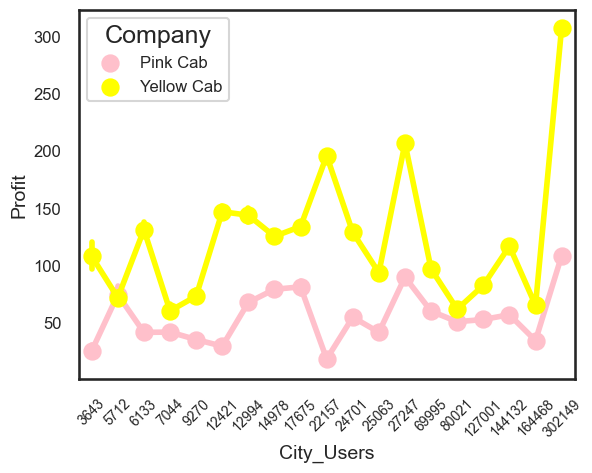

In [165]:
sns.pointplot(data=data,x='City_Users',y='Profit'
             ,hue='Company',palette=["pink", "yellow"])
plt.xticks(rotation=45,fontsize=10)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, '248968'),
  Text(1, 0, '327225'),
  Text(2, 0, '418859'),
  Text(3, 0, '542085'),
  Text(4, 0, '545776'),
  Text(5, 0, '631442'),
  Text(6, 0, '671238'),
  Text(7, 0, '698371'),
  Text(8, 0, '754233'),
  Text(9, 0, '814885'),
  Text(10, 0, '942908'),
  Text(11, 0, '943999'),
  Text(12, 0, '959307'),
  Text(13, 0, '1030185'),
  Text(14, 0, '1177609'),
  Text(15, 0, '1339155'),
  Text(16, 0, '1595037'),
  Text(17, 0, '1955130'),
  Text(18, 0, '8405837')])

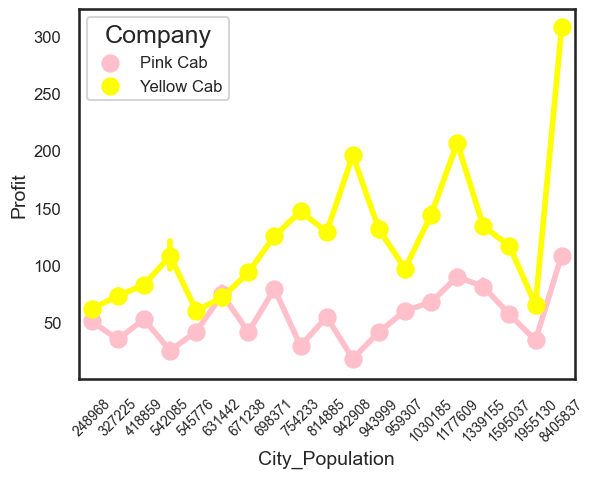

In [166]:
sns.pointplot(data=data,x='City_Population',y='Profit'
             ,hue='Company',palette=["pink", "yellow"])
plt.xticks(rotation=45,fontsize=10)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, '0.6496828916132327'),
  Text(1, 0, '0.6720348284863075'),
  Text(2, 0, '0.9045961465977873'),
  Text(3, 0, '1.261326849061091'),
  Text(4, 0, '1.2906393831901732'),
  Text(5, 0, '1.3198621518793567'),
  Text(6, 0, '1.6468385764080862'),
  Text(7, 0, '2.14470532138362'),
  Text(8, 0, '2.3137560939157225'),
  Text(9, 0, '2.3498580985631685'),
  Text(10, 0, '2.832913133165253'),
  Text(11, 0, '3.0312252649146814'),
  Text(12, 0, '3.5945141453492377'),
  Text(13, 0, '3.733847011045263'),
  Text(14, 0, '7.2964129314182005'),
  Text(15, 0, '8.412126047884284'),
  Text(16, 0, '9.036279409192389'),
  Text(17, 0, '30.32070458077778'),
  Text(18, 0, '32.14107837151762')])

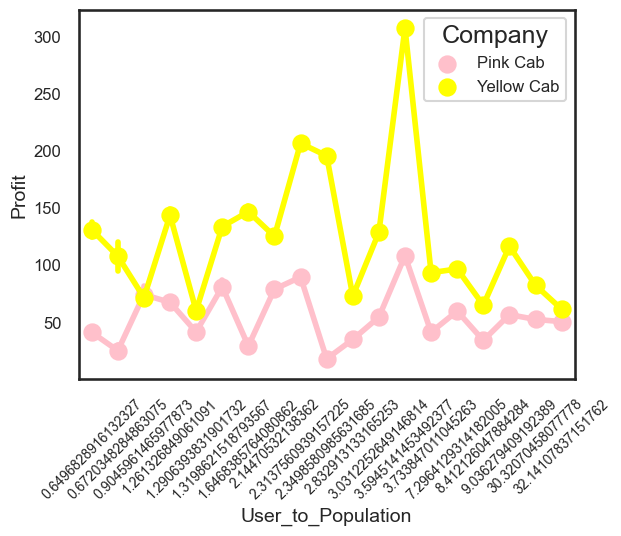

In [167]:
sns.pointplot(data=data,x='User_to_Population',y='Profit'
             ,hue='Company',palette=["pink", "yellow"])
plt.xticks(rotation=45,fontsize=10)

### Observation:
* cab order counts show perodic behaviour over time for both companies.
2017 May to October shows the highest user counts. there is trend of increase the usrers towards summer months and drop druing the fall then starting to increase again.  

* Price Charged attribute shows periodic behavior with maximum charges aroung the holiday season and minimum in spring.   
* There is a clear decreasing in the price charged for yellow compnay while the pink compny did not show any decrease or increasing trend.
* Cost of trip is higher for Yellow cab than pink cab but there is no periodic changes. 
* Profit is higher for Yellow cab. it is higher in spring. while for Pink cab is higher in winter.
* May is the month with high profit for yellow cab, while December is the profitable month for Pink cab. 
*  Tuesday is most profitable day for both companies. 
* profit increase with increase the city populations and city users. the increase is much clear for yellow compnay than pink company. 
* The ratio of users to city population does not effect the profit. 

In [168]:
data.select_dtypes('number').columns

Index(['Transaction ID', 'KM Travelled', 'Price Charged', 'Cost of Trip',
       'City_Population', 'City_Users', 'Age', 'Income', 'Year', 'Week', 'Day',
       'Month', 'User_to_Population', 'Profit'],
      dtype='object')

<AxesSubplot:>

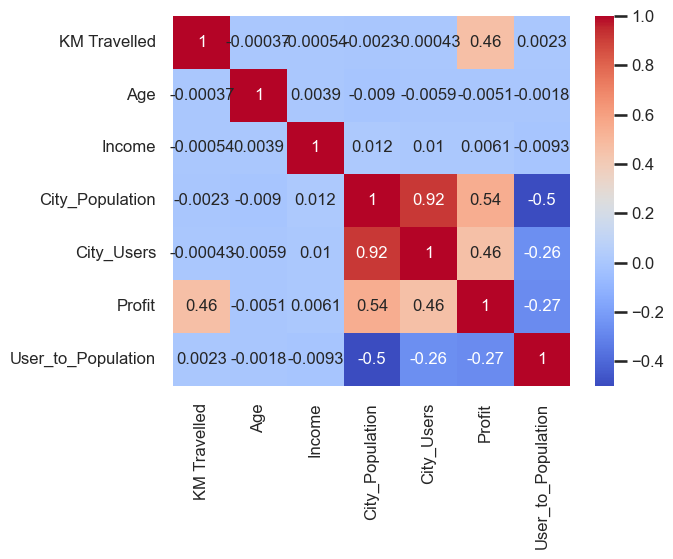

In [169]:
sns.heatmap(data=data[[ 'KM Travelled',
       'Age', 'Income', 
       'City_Population', 'City_Users', 'Profit','User_to_Population']].corr(),annot=True,cmap='coolwarm')

### observation 
* There is correlation between City population and city users.
* there is a seasonality in users data
* Gender does not have effect on users
* City Population affect the the profit and the number of trip

## Hypotheses:

#### Hypothesis 1:   
 Is there any difference in profit regarding Gender
* H0 : There is no difference regarding Gender in both cab companies.
* H1 : There is difference regarding Gender in both cab companies.

In [178]:
a = data[(data.Gender=='Male')&(data.Company=='Pink Cab')].groupby('Transaction ID').Profit.mean()
b = data[(data.Gender=='Female')&(data.Company=='Pink Cab')].groupby('Transaction ID').Profit.mean()
print(a.shape[0],b.shape[0])

_, p_value = stats.ttest_ind(a.values,
                             b.values,
                             equal_var=True)

print('P value is ', p_value)

if p_value < 0.05:
    print(f'As the p-value {p_value} is less than the level of significance, we reject the null hypothesis.')
else:
    print(f'As the p-value {p_value} is greater than the level of significance, we fail to reject the null hypothesis.')

47231 37480
P value is  0.115153059004258
As the p-value 0.115153059004258 is greater than the level of significance, we fail to reject the null hypothesis.


In [185]:
a = data[(data.Gender=='Male')&(data.Company=='Yellow Cab')].groupby('Transaction ID').Profit.mean()
b = data[(data.Gender=='Female')&(data.Company=='Yellow Cab')].groupby('Transaction ID').Profit.mean()
print(a.shape[0],b.shape[0])

_, p_value = stats.ttest_ind(a.values,
                             b.values,
                             equal_var=True)

print('P value is ', p_value)

if p_value < 0.05:
    print(f'As the p-value {p_value} is less than the level of significance, we reject the null hypothesis.')
else:
    print(f'As the p-value {p_value} is greater than the level of significance, we fail to reject the null hypothesis.')    

158681 116000
P value is  6.060473042494056e-25
As the p-value 6.060473042494056e-25 is less than the level of significance, we reject the null hypothesis.


* Yellow Cab: there is difference between male and female. 
* Pink Cab: there is no difference. 

#### Hypothesis 2:   
Is there any difference in Profit regarding Age   
* H0 : There is no difference regarding Age in both cab companies.   
mean Yellow cab=mean Pink cab
* H1 : There is difference regarding Age in both cab companies.   
mean Yellow cab != mean Pink cab

In [184]:
a = data[(data.Age <= 60)&(data.Company=='Pink Cab')].groupby('Transaction ID').Profit.mean()
b = data[(data.Age >= 60)&(data.Company=='Pink Cab')].groupby('Transaction ID').Profit.mean()
print(a.shape[0],b.shape[0])

_, p_value = stats.ttest_ind(a.values,
                             b.values,
                             equal_var=True)

print('P value is ', p_value)

if p_value < 0.05:
    print(f'As the p-value {p_value} is less than the level of significance, we reject the null hypothesis.')
else:
    print(f'As the p-value {p_value} is greater than the level of significance, we fail to reject the null hypothesis.')    

80125 5429
P value is  0.4816748536155634
As the p-value 0.4816748536155634 is greater than the level of significance, we fail to reject the null hypothesis.


In [181]:
a = data[(df.Age <= 60)&(data.Company=='Yellow Cab')].groupby('Transaction ID').Profit.mean()
b = data[(df.Age >= 60)&(data.Company=='Yellow Cab')].groupby('Transaction ID').Profit.mean()
print(a.shape[0],b.shape[0])

_, p_value = stats.ttest_ind(a.values,
                             b.values,
                             equal_var=True)

print('P value is ', p_value)

if p_value < 0.05:
    print(f'As the p-value {p_value} is less than the level of significance, we reject the null hypothesis.')
else:
    print(f'As the p-value {p_value} is greater than the level of significance, we fail to reject the null hypothesis.')

260356 17257
P value is  6.328485471267631e-05
As the p-value 6.328485471267631e-05 is less than the level of significance, we reject the null hypothesis.


* Yellow Cab has difference based on Age
* Pink Cab  has no difference based on Age 

Looks like Yellow Cab company offers discounts for seniors 

#### Hypothesis 3: 
  
Is there any difference in Profit regarding Payment mode   
* H0 : There is no difference regarding Payment_Mode in both cab companies.
* H1 : There is difference regarding Payment_Mode in both cab companies..

In [186]:
a = data[(data['Payment_Mode']=='Cash')&(data.Company=='Pink Cab')].groupby('Transaction ID').Profit.mean()
b = data[(data['Payment_Mode']=='Card')&(data.Company=='Pink Cab')].groupby('Transaction ID').Profit.mean()

_, p_value = stats.ttest_ind(a.values,
                             b.values,
                             equal_var=True)

print('P value is ', p_value)

    
if p_value < 0.05:
    print(f'As the p-value {p_value} is less than the level of significance, we reject the null hypothesis.')
else:
    print(f'As the p-value {p_value} is greater than the level of significance, we fail to reject the null hypothesis.')    

P value is  0.7900465828793286
As the p-value 0.7900465828793286 is greater than the level of significance, we fail to reject the null hypothesis.


In [187]:
a =data[(data['Payment_Mode']=='Cash')&(data.Company=='Yellow Cab')].groupby('Transaction ID').Profit.mean()
b = data[(data['Payment_Mode']=='Card')&(data.Company=='Yellow Cab')].groupby('Transaction ID').Profit.mean()

_, p_value = stats.ttest_ind(a.values,
                             b.values,
                             equal_var=True)

print('P value is ', p_value)

if p_value < 0.05:
    print(f'As the p-value {p_value} is less than the level of significance, we reject the null hypothesis.')
else:
    print(f'As the p-value {p_value} is greater than the level of significance, we fail to reject the null hypothesis.')

P value is  0.29330606382987284
As the p-value 0.29330606382987284 is greater than the level of significance, we fail to reject the null hypothesis.


* Yellow Cab has no difference based on payment mode
* Pink Cab  has no difference based on payment mode